In [81]:
import torch
import torch.nn as nn
import yaml
import torch.distributions as distributions
import torch.optim as optim
from critic import Criticnet, SmallMLP
from scorenet import Scorenet
import os
from datasets import toy_data
import numpy as np 
import matplotlib
from utils import keep_grad, approx_jacobian_trace, exact_jacobian_trace, \
    set_random_seed, get_logger, dict2namespace, get_opt, visualize_2d, langevin_dynamics_lsd
import importlib
import argparse
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

config_file = './test_config_toy_2d.yaml'

def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

with open(config_file, 'r') as f:
    config = yaml.load(f)
        
cfg = dict2namespace(config)
cfg

/nfs/rhea.dgp/u6/a/mrsalehi/.virtualenvs/base/lib/python3.6/site-packages/ipykernel_launcher.py:16: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  app.launch_new_instance()


Namespace(data=Namespace(batch_size=1, cates=None, data_dir=None, dataset_scale=1, dataset_type='pinwheel', normalize_per_shape=False, normalize_std_per_axis=False, num_workers=4, recenter_per_shape=True, te_max_sample_points=2048, tr_max_sample_points=2048, type='pinwheel'), inference=Namespace(num_points=2048, num_steps=10, step_size_ratio=1, weight=1), log=Namespace(log_freq=10, save_dir='log/test-toy-2d', save_freq=200, val_freq=100, viz_freq=100), models=Namespace(scorenet=Namespace(dim=3, hidden_size=256, n_blocks=24, out_dim=3, param_likelihood=False, sigma_condition=True, type='models.decoders.resnet_add', xyz_condition=True, z_dim=128)), trainer=Namespace(c_iters=10, epochs=2000, opt_criticnet=Namespace(beta1=0.9, beta2=0.999, iters=10, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), opt_scorenet=Namespace(beta1=0.9, beta2=0.999, lr='1e-3', momentum=0.9, scheduler='linear', step_epoch=2000, type='adam', weight_decay=0.0), s_iters=1

In [83]:
def sample_data(data, n_points):
    x = toy_data.inf_train_gen(data, n_points=n_points)
#     plt.scatter(x[:, 0], x[:, 1])
    x = torch.from_numpy(x).type(torch.float32).to(device)
    return x

In [84]:
_ = sample_data('moons', 1000)

In [85]:
score_net = SmallMLP(n_dims=2, n_out=2)
critic_net = SmallMLP(n_dims=2, n_out=2)

critic_net.to(device)
score_net.to(device)

opt_scorenet, scheduler_scorenet = get_opt(score_net.parameters(), cfg.trainer.opt_scorenet)
opt_criticnet, scheduler_criticnet = get_opt(critic_net.parameters(), cfg.trainer.opt_scorenet)

k_iters = 5
e_iters = 1
epochs = 15000
itr = 0

losses = []

for epoch in range(epochs):
    tr_pts = sample_data('moons', 2048).view(-1, 2)
    
    score_net.train()
    critic_net.train()
    opt_scorenet.zero_grad()
    opt_criticnet.zero_grad()

    tr_pts.requires_grad_()
    batch_size = tr_pts.size(0)

    perturbed_points = tr_pts

    score_pred = score_net(perturbed_points)

    critic_output = critic_net(perturbed_points)

    t1 = (score_pred * critic_output).sum(-1)
    t2 = exact_jacobian_trace(critic_output, perturbed_points)

    stein = t1 + t2
    l2_penalty = (critic_output * critic_output).sum(-1).mean()
    loss = stein.mean()

    losses.append(loss)

    cycle_iter = itr % (k_iters + e_iters)

    cpu_loss = loss.detach().cpu().item()
    cpu_t1 = t1.mean().detach().cpu().item()
    cpu_t2 = t2.mean().detach().cpu().item()

    if cycle_iter < k_iters:
        (-loss + l2_penalty).backward()
        opt_criticnet.step()
        log_message = "Epoch %d (critic), Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2)
    else:
        loss.backward()
        opt_scorenet.step()
        log_message = "Epoch %d (score), Loss=%2.5f t1=%2.5f t2=%2.5f" % (epoch, cpu_loss, cpu_t1, cpu_t2)

    print(log_message)
    itr += 1

#     if itr % cfg.log.save_freq == 0:
#         score_net.cpu()

#         torch.save({
#             'args': args,
#             'state_dict': score_net.state_dict(),
#         }, os.path.join(cfg.log.save_dir, 'checkpt.pth'))

#         score_net.to(device)

#     if itr % cfg.log.viz_freq == 0:
#         plt.clf()

#         #pt_cl, _ = langevin_dynamics(score_net, sigmas, dim=2, eps=1e-4, num_steps=cfg.inference.num_steps)
#         x_final = langevin_dynamics_lsd(score_net, l=1., e=.01, num_points=2048, n_steps=10)

#         visualize_2d(x_final)

#         fig_filename = os.path.join(cfg.log.save_dir, 'figs', 'sample-{:04d}.png'.format(itr))
#         os.makedirs(os.path.dirname(fig_filename), exist_ok=True)
#         plt.savefig(fig_filename)


#         visualize_2d(perturbed_points)

#         fig_filename = os.path.join(cfg.log.save_dir, 'figs', 'perturbed-{:04d}.png'.format(itr))
#         os.makedirs(os.path.dirname(fig_filename), exist_ok=True)
#         plt.savefig(fig_filename)

#     itr += 1

Epoch 0 (critic), Loss=-0.00870 t1=0.00243 t2=-0.01113
Epoch 1 (critic), Loss=0.37401 t1=0.00195 t2=0.37206
Epoch 2 (critic), Loss=0.74231 t1=0.00003 t2=0.74228
Epoch 3 (critic), Loss=1.09244 t1=-0.00292 t2=1.09536
Epoch 4 (critic), Loss=1.41990 t1=-0.00731 t2=1.42721
Epoch 5 (score), Loss=1.72000 t1=-0.01140 t2=1.73140
Epoch 6 (critic), Loss=1.53479 t1=-0.19557 t2=1.73036
Epoch 7 (critic), Loss=1.77836 t1=-0.20243 t2=1.98079
Epoch 8 (critic), Loss=1.99441 t1=-0.19711 t2=2.19152
Epoch 9 (critic), Loss=2.19245 t1=-0.18630 t2=2.37874
Epoch 10 (critic), Loss=2.38639 t1=-0.17118 t2=2.55756
Epoch 11 (score), Loss=2.57863 t1=-0.15925 t2=2.73788
Epoch 12 (critic), Loss=2.42941 t1=-0.30808 t2=2.73749
Epoch 13 (critic), Loss=2.61749 t1=-0.29177 t2=2.90926
Epoch 14 (critic), Loss=2.79567 t1=-0.27702 t2=3.07269
Epoch 15 (critic), Loss=2.95902 t1=-0.26298 t2=3.22199
Epoch 16 (critic), Loss=3.09522 t1=-0.26026 t2=3.35548
Epoch 17 (score), Loss=3.19390 t1=-0.25909 t2=3.45299
Epoch 18 (critic), Loss=

Epoch 161 (score), Loss=10.75919 t1=0.60060 t2=10.15859
Epoch 162 (critic), Loss=10.91907 t1=0.53505 t2=10.38402
Epoch 163 (critic), Loss=11.18358 t1=0.55975 t2=10.62382
Epoch 164 (critic), Loss=11.38182 t1=0.48368 t2=10.89814
Epoch 165 (critic), Loss=11.68507 t1=0.61517 t2=11.06989
Epoch 166 (critic), Loss=11.88285 t1=0.64739 t2=11.23546
Epoch 167 (score), Loss=11.82700 t1=0.46798 t2=11.35901
Epoch 168 (critic), Loss=11.80753 t1=0.49302 t2=11.31451
Epoch 169 (critic), Loss=12.22104 t1=0.20158 t2=12.01945
Epoch 170 (critic), Loss=12.29313 t1=0.23099 t2=12.06213
Epoch 171 (critic), Loss=12.92691 t1=0.40418 t2=12.52274
Epoch 172 (critic), Loss=12.56480 t1=0.45666 t2=12.10814
Epoch 173 (score), Loss=13.05458 t1=0.26000 t2=12.79458
Epoch 174 (critic), Loss=13.00886 t1=0.46451 t2=12.54434
Epoch 175 (critic), Loss=13.18388 t1=0.25054 t2=12.93334
Epoch 176 (critic), Loss=13.30002 t1=0.34198 t2=12.95804
Epoch 177 (critic), Loss=13.76436 t1=0.42287 t2=13.34149
Epoch 178 (critic), Loss=13.88031 

Epoch 327 (critic), Loss=29.17991 t1=0.09493 t2=29.08498
Epoch 328 (critic), Loss=29.48536 t1=0.09554 t2=29.38982
Epoch 329 (score), Loss=29.44013 t1=-0.25830 t2=29.69843
Epoch 330 (critic), Loss=29.57177 t1=-0.28605 t2=29.85782
Epoch 331 (critic), Loss=29.46000 t1=-0.92933 t2=30.38933
Epoch 332 (critic), Loss=30.09044 t1=-0.53089 t2=30.62133
Epoch 333 (critic), Loss=29.51947 t1=0.01395 t2=29.50552
Epoch 334 (critic), Loss=29.59667 t1=0.04520 t2=29.55148
Epoch 335 (score), Loss=29.88839 t1=0.23406 t2=29.65433
Epoch 336 (critic), Loss=29.80903 t1=0.35109 t2=29.45795
Epoch 337 (critic), Loss=29.80313 t1=0.10179 t2=29.70134
Epoch 338 (critic), Loss=30.40326 t1=-0.22362 t2=30.62688
Epoch 339 (critic), Loss=30.05198 t1=-0.08951 t2=30.14150
Epoch 340 (critic), Loss=30.08970 t1=-0.39194 t2=30.48163
Epoch 341 (score), Loss=29.86421 t1=0.02073 t2=29.84348
Epoch 342 (critic), Loss=29.92369 t1=0.01977 t2=29.90392
Epoch 343 (critic), Loss=29.53077 t1=-0.14164 t2=29.67241
Epoch 344 (critic), Loss=3

Epoch 478 (critic), Loss=34.03362 t1=0.07131 t2=33.96231
Epoch 479 (score), Loss=34.03415 t1=-0.26495 t2=34.29910
Epoch 480 (critic), Loss=34.47762 t1=-0.86763 t2=35.34526
Epoch 481 (critic), Loss=34.25537 t1=-0.11418 t2=34.36956
Epoch 482 (critic), Loss=34.46146 t1=-0.20317 t2=34.66463
Epoch 483 (critic), Loss=33.99377 t1=0.35626 t2=33.63750
Epoch 484 (critic), Loss=33.77151 t1=-0.13110 t2=33.90261
Epoch 485 (score), Loss=34.01920 t1=0.15428 t2=33.86491
Epoch 486 (critic), Loss=34.17303 t1=-0.36672 t2=34.53976
Epoch 487 (critic), Loss=34.03280 t1=-0.02802 t2=34.06082
Epoch 488 (critic), Loss=34.09193 t1=-0.24241 t2=34.33434
Epoch 489 (critic), Loss=34.32344 t1=-1.07525 t2=35.39869
Epoch 490 (critic), Loss=34.32572 t1=-0.54731 t2=34.87304
Epoch 491 (score), Loss=33.96249 t1=-0.07594 t2=34.03843
Epoch 492 (critic), Loss=34.47339 t1=-0.48383 t2=34.95722
Epoch 493 (critic), Loss=33.99062 t1=-0.45885 t2=34.44947
Epoch 494 (critic), Loss=33.75166 t1=-0.19572 t2=33.94738
Epoch 495 (critic), 

Epoch 624 (critic), Loss=35.37865 t1=-0.69233 t2=36.07099
Epoch 625 (critic), Loss=35.22387 t1=-1.34145 t2=36.56532
Epoch 626 (critic), Loss=36.23087 t1=-0.47113 t2=36.70200
Epoch 627 (critic), Loss=35.66779 t1=-0.00941 t2=35.67720
Epoch 628 (critic), Loss=35.31882 t1=0.00301 t2=35.31580
Epoch 629 (score), Loss=36.21519 t1=-0.28587 t2=36.50106
Epoch 630 (critic), Loss=36.09006 t1=0.02688 t2=36.06318
Epoch 631 (critic), Loss=36.02499 t1=0.00243 t2=36.02256
Epoch 632 (critic), Loss=35.78059 t1=-1.24500 t2=37.02559
Epoch 633 (critic), Loss=35.57943 t1=-1.48005 t2=37.05948
Epoch 634 (critic), Loss=35.81380 t1=-0.81730 t2=36.63110
Epoch 635 (score), Loss=35.91299 t1=-1.09957 t2=37.01257
Epoch 636 (critic), Loss=35.45679 t1=-1.65015 t2=37.10694
Epoch 637 (critic), Loss=35.87444 t1=-0.33469 t2=36.20913
Epoch 638 (critic), Loss=35.57562 t1=0.01151 t2=35.56411
Epoch 639 (critic), Loss=35.89590 t1=0.28820 t2=35.60770
Epoch 640 (critic), Loss=36.00300 t1=0.06820 t2=35.93480
Epoch 641 (score), Los

Epoch 769 (critic), Loss=35.38436 t1=-1.61480 t2=36.99916
Epoch 770 (critic), Loss=35.10170 t1=-2.41421 t2=37.51590
Epoch 771 (critic), Loss=35.16893 t1=-1.55734 t2=36.72627
Epoch 772 (critic), Loss=35.45530 t1=-1.49139 t2=36.94670
Epoch 773 (score), Loss=34.95847 t1=-1.35615 t2=36.31463
Epoch 774 (critic), Loss=34.97124 t1=-2.02052 t2=36.99176
Epoch 775 (critic), Loss=34.90442 t1=-2.03894 t2=36.94335
Epoch 776 (critic), Loss=34.97935 t1=-1.34741 t2=36.32676
Epoch 777 (critic), Loss=34.56624 t1=-1.86532 t2=36.43156
Epoch 778 (critic), Loss=34.88403 t1=-2.32636 t2=37.21038
Epoch 779 (score), Loss=34.87123 t1=-1.52064 t2=36.39187
Epoch 780 (critic), Loss=34.58064 t1=-1.98188 t2=36.56252
Epoch 781 (critic), Loss=34.92741 t1=-2.21748 t2=37.14490
Epoch 782 (critic), Loss=35.84008 t1=-1.35022 t2=37.19030
Epoch 783 (critic), Loss=35.27906 t1=-2.09305 t2=37.37210
Epoch 784 (critic), Loss=35.27080 t1=-2.01657 t2=37.28736
Epoch 785 (score), Loss=34.58318 t1=-1.77876 t2=36.36193
Epoch 786 (critic

Epoch 914 (critic), Loss=32.28967 t1=-1.82335 t2=34.11302
Epoch 915 (critic), Loss=32.02644 t1=-2.25595 t2=34.28239
Epoch 916 (critic), Loss=32.68375 t1=-2.23255 t2=34.91630
Epoch 917 (score), Loss=32.29925 t1=-2.52594 t2=34.82518
Epoch 918 (critic), Loss=32.32612 t1=-2.39686 t2=34.72298
Epoch 919 (critic), Loss=31.56052 t1=-3.03490 t2=34.59541
Epoch 920 (critic), Loss=31.52030 t1=-3.21368 t2=34.73397
Epoch 921 (critic), Loss=31.34241 t1=-3.44110 t2=34.78352
Epoch 922 (critic), Loss=31.52996 t1=-2.89390 t2=34.42385
Epoch 923 (score), Loss=32.08489 t1=-2.14068 t2=34.22557
Epoch 924 (critic), Loss=32.06190 t1=-1.92311 t2=33.98502
Epoch 925 (critic), Loss=31.74915 t1=-2.72157 t2=34.47071
Epoch 926 (critic), Loss=31.79308 t1=-3.14112 t2=34.93420
Epoch 927 (critic), Loss=32.30186 t1=-2.81276 t2=35.11462
Epoch 928 (critic), Loss=32.51714 t1=-2.19536 t2=34.71250
Epoch 929 (score), Loss=32.31697 t1=-1.52314 t2=33.84011
Epoch 930 (critic), Loss=31.18928 t1=-2.76960 t2=33.95888
Epoch 931 (critic

Epoch 1058 (critic), Loss=28.35432 t1=-3.46900 t2=31.82333
Epoch 1059 (critic), Loss=27.10548 t1=-5.21247 t2=32.31795
Epoch 1060 (critic), Loss=28.21186 t1=-4.76782 t2=32.97968
Epoch 1061 (score), Loss=28.11391 t1=-4.19537 t2=32.30928
Epoch 1062 (critic), Loss=26.77168 t1=-5.25262 t2=32.02430
Epoch 1063 (critic), Loss=27.88353 t1=-3.85339 t2=31.73692
Epoch 1064 (critic), Loss=27.63961 t1=-3.42943 t2=31.06904
Epoch 1065 (critic), Loss=28.09743 t1=-2.49789 t2=30.59533
Epoch 1066 (critic), Loss=27.97140 t1=-3.37538 t2=31.34678
Epoch 1067 (score), Loss=27.04310 t1=-4.25337 t2=31.29647
Epoch 1068 (critic), Loss=27.61300 t1=-3.66468 t2=31.27768
Epoch 1069 (critic), Loss=26.95755 t1=-4.98692 t2=31.94447
Epoch 1070 (critic), Loss=27.21583 t1=-4.56634 t2=31.78216
Epoch 1071 (critic), Loss=27.65482 t1=-4.21520 t2=31.87003
Epoch 1072 (critic), Loss=27.80885 t1=-3.66471 t2=31.47356
Epoch 1073 (score), Loss=27.28838 t1=-3.50866 t2=30.79704
Epoch 1074 (critic), Loss=27.34685 t1=-3.63546 t2=30.98231


Epoch 1202 (critic), Loss=23.77395 t1=-3.69794 t2=27.47189
Epoch 1203 (critic), Loss=23.71463 t1=-4.57256 t2=28.28719
Epoch 1204 (critic), Loss=22.92429 t1=-4.77577 t2=27.70006
Epoch 1205 (score), Loss=22.50332 t1=-5.44256 t2=27.94588
Epoch 1206 (critic), Loss=23.67470 t1=-4.78347 t2=28.45817
Epoch 1207 (critic), Loss=22.85025 t1=-5.24059 t2=28.09084
Epoch 1208 (critic), Loss=23.53464 t1=-4.56569 t2=28.10033
Epoch 1209 (critic), Loss=23.11905 t1=-4.31215 t2=27.43121
Epoch 1210 (critic), Loss=24.18003 t1=-3.09229 t2=27.27232
Epoch 1211 (score), Loss=24.07661 t1=-2.97586 t2=27.05247
Epoch 1212 (critic), Loss=23.14668 t1=-3.71824 t2=26.86492
Epoch 1213 (critic), Loss=23.14108 t1=-3.99997 t2=27.14105
Epoch 1214 (critic), Loss=23.13042 t1=-3.80616 t2=26.93657
Epoch 1215 (critic), Loss=23.31172 t1=-4.04991 t2=27.36163
Epoch 1216 (critic), Loss=22.92021 t1=-4.64022 t2=27.56043
Epoch 1217 (score), Loss=23.05864 t1=-4.65634 t2=27.71498
Epoch 1218 (critic), Loss=23.46165 t1=-4.12689 t2=27.58854


Epoch 1347 (critic), Loss=20.97036 t1=-3.07464 t2=24.04500
Epoch 1348 (critic), Loss=20.96791 t1=-2.50509 t2=23.47300
Epoch 1349 (score), Loss=20.63384 t1=-3.07033 t2=23.70417
Epoch 1350 (critic), Loss=20.19231 t1=-3.76933 t2=23.96164
Epoch 1351 (critic), Loss=20.60590 t1=-3.53997 t2=24.14587
Epoch 1352 (critic), Loss=21.01954 t1=-2.83525 t2=23.85479
Epoch 1353 (critic), Loss=20.47437 t1=-3.41087 t2=23.88524
Epoch 1354 (critic), Loss=20.49775 t1=-3.51787 t2=24.01561
Epoch 1355 (score), Loss=21.20902 t1=-3.27161 t2=24.48063
Epoch 1356 (critic), Loss=20.08574 t1=-3.57610 t2=23.66184
Epoch 1357 (critic), Loss=20.68999 t1=-3.02649 t2=23.71648
Epoch 1358 (critic), Loss=20.43155 t1=-3.47118 t2=23.90273
Epoch 1359 (critic), Loss=20.69445 t1=-3.02111 t2=23.71556
Epoch 1360 (critic), Loss=20.87095 t1=-3.03245 t2=23.90339
Epoch 1361 (score), Loss=20.76732 t1=-3.02029 t2=23.78760
Epoch 1362 (critic), Loss=20.26758 t1=-3.32540 t2=23.59298
Epoch 1363 (critic), Loss=20.54962 t1=-3.33845 t2=23.88807


Epoch 1491 (critic), Loss=18.02504 t1=-3.20370 t2=21.22874
Epoch 1492 (critic), Loss=17.67468 t1=-3.26962 t2=20.94430
Epoch 1493 (score), Loss=18.82288 t1=-2.87134 t2=21.69421
Epoch 1494 (critic), Loss=18.58367 t1=-3.11833 t2=21.70200
Epoch 1495 (critic), Loss=18.79330 t1=-2.66946 t2=21.46276
Epoch 1496 (critic), Loss=18.31105 t1=-3.69927 t2=22.01032
Epoch 1497 (critic), Loss=19.24881 t1=-2.78366 t2=22.03247
Epoch 1498 (critic), Loss=17.94514 t1=-3.57834 t2=21.52348
Epoch 1499 (score), Loss=18.72818 t1=-2.68201 t2=21.41019
Epoch 1500 (critic), Loss=18.51528 t1=-2.79052 t2=21.30580
Epoch 1501 (critic), Loss=18.82317 t1=-2.41650 t2=21.23968
Epoch 1502 (critic), Loss=18.60614 t1=-2.72844 t2=21.33458
Epoch 1503 (critic), Loss=18.67319 t1=-2.90978 t2=21.58297
Epoch 1504 (critic), Loss=18.84929 t1=-2.45946 t2=21.30875
Epoch 1505 (score), Loss=18.38376 t1=-2.56985 t2=20.95361
Epoch 1506 (critic), Loss=18.45046 t1=-2.39557 t2=20.84603
Epoch 1507 (critic), Loss=18.45787 t1=-2.56704 t2=21.02491


Epoch 1633 (critic), Loss=17.00164 t1=-3.36419 t2=20.36583
Epoch 1634 (critic), Loss=17.19110 t1=-3.21552 t2=20.40662
Epoch 1635 (critic), Loss=17.73924 t1=-2.59960 t2=20.33884
Epoch 1636 (critic), Loss=17.47291 t1=-2.89223 t2=20.36514
Epoch 1637 (score), Loss=17.30956 t1=-2.97673 t2=20.28629
Epoch 1638 (critic), Loss=17.53755 t1=-2.64610 t2=20.18365
Epoch 1639 (critic), Loss=17.66772 t1=-3.02602 t2=20.69373
Epoch 1640 (critic), Loss=17.63043 t1=-3.25886 t2=20.88929
Epoch 1641 (critic), Loss=17.68738 t1=-2.94818 t2=20.63556
Epoch 1642 (critic), Loss=17.94368 t1=-2.81794 t2=20.76163
Epoch 1643 (score), Loss=17.22709 t1=-2.96065 t2=20.18774
Epoch 1644 (critic), Loss=17.53306 t1=-2.77092 t2=20.30398
Epoch 1645 (critic), Loss=17.33331 t1=-2.95302 t2=20.28633
Epoch 1646 (critic), Loss=17.64856 t1=-2.43082 t2=20.07939
Epoch 1647 (critic), Loss=18.08676 t1=-1.88844 t2=19.97520
Epoch 1648 (critic), Loss=17.89278 t1=-2.44723 t2=20.34001
Epoch 1649 (score), Loss=17.62446 t1=-2.02951 t2=19.65397


Epoch 1777 (critic), Loss=16.32376 t1=-2.32828 t2=18.65204
Epoch 1778 (critic), Loss=16.09953 t1=-2.67977 t2=18.77930
Epoch 1779 (critic), Loss=16.06397 t1=-2.42322 t2=18.48719
Epoch 1780 (critic), Loss=16.24049 t1=-2.01350 t2=18.25398
Epoch 1781 (score), Loss=16.43046 t1=-1.75545 t2=18.18591
Epoch 1782 (critic), Loss=15.71991 t1=-1.91485 t2=17.63476
Epoch 1783 (critic), Loss=15.94792 t1=-2.46728 t2=18.41520
Epoch 1784 (critic), Loss=16.05756 t1=-2.80956 t2=18.86712
Epoch 1785 (critic), Loss=16.07992 t1=-2.66655 t2=18.74647
Epoch 1786 (critic), Loss=16.36522 t1=-2.24391 t2=18.60913
Epoch 1787 (score), Loss=16.17408 t1=-2.65586 t2=18.82994
Epoch 1788 (critic), Loss=15.74802 t1=-2.68610 t2=18.43412
Epoch 1789 (critic), Loss=15.41857 t1=-3.31660 t2=18.73516
Epoch 1790 (critic), Loss=16.19017 t1=-3.27453 t2=19.46470
Epoch 1791 (critic), Loss=15.76516 t1=-3.66279 t2=19.42794
Epoch 1792 (critic), Loss=16.82180 t1=-3.69255 t2=20.51435
Epoch 1793 (score), Loss=17.03211 t1=-3.19831 t2=20.23042


Epoch 1921 (critic), Loss=15.08920 t1=-2.19811 t2=17.28731
Epoch 1922 (critic), Loss=15.36312 t1=-2.06103 t2=17.42415
Epoch 1923 (critic), Loss=15.30739 t1=-2.38776 t2=17.69515
Epoch 1924 (critic), Loss=15.61728 t1=-2.21594 t2=17.83322
Epoch 1925 (score), Loss=14.89765 t1=-3.03360 t2=17.93126
Epoch 1926 (critic), Loss=15.22969 t1=-2.77682 t2=18.00650
Epoch 1927 (critic), Loss=14.89107 t1=-3.32343 t2=18.21450
Epoch 1928 (critic), Loss=15.22708 t1=-2.86675 t2=18.09383
Epoch 1929 (critic), Loss=15.33114 t1=-2.27645 t2=17.60759
Epoch 1930 (critic), Loss=15.08018 t1=-1.97274 t2=17.05292
Epoch 1931 (score), Loss=15.38038 t1=-1.64657 t2=17.02695
Epoch 1932 (critic), Loss=15.41430 t1=-2.12035 t2=17.53464
Epoch 1933 (critic), Loss=15.23426 t1=-2.50625 t2=17.74052
Epoch 1934 (critic), Loss=15.64341 t1=-2.79261 t2=18.43601
Epoch 1935 (critic), Loss=15.20950 t1=-3.01893 t2=18.22843
Epoch 1936 (critic), Loss=15.55547 t1=-2.79662 t2=18.35210
Epoch 1937 (score), Loss=15.60478 t1=-2.72870 t2=18.33348


Epoch 2065 (critic), Loss=14.37581 t1=-2.30421 t2=16.68002
Epoch 2066 (critic), Loss=14.21191 t1=-2.10803 t2=16.31994
Epoch 2067 (critic), Loss=14.21521 t1=-2.40710 t2=16.62231
Epoch 2068 (critic), Loss=14.93710 t1=-1.63003 t2=16.56713
Epoch 2069 (score), Loss=14.39710 t1=-2.03250 t2=16.42961
Epoch 2070 (critic), Loss=14.70320 t1=-1.89294 t2=16.59614
Epoch 2071 (critic), Loss=14.05116 t1=-2.28037 t2=16.33152
Epoch 2072 (critic), Loss=14.69659 t1=-1.34233 t2=16.03892
Epoch 2073 (critic), Loss=14.82426 t1=-0.85412 t2=15.67838
Epoch 2074 (critic), Loss=14.51941 t1=-1.48014 t2=15.99955
Epoch 2075 (score), Loss=14.52215 t1=-1.55438 t2=16.07652
Epoch 2076 (critic), Loss=13.69244 t1=-2.07212 t2=15.76455
Epoch 2077 (critic), Loss=14.31001 t1=-2.47221 t2=16.78223
Epoch 2078 (critic), Loss=14.50953 t1=-2.10706 t2=16.61658
Epoch 2079 (critic), Loss=14.23450 t1=-2.53712 t2=16.77162
Epoch 2080 (critic), Loss=15.26061 t1=-1.61457 t2=16.87518
Epoch 2081 (score), Loss=14.73582 t1=-1.35668 t2=16.09250


Epoch 2209 (critic), Loss=13.21721 t1=-3.35113 t2=16.56833
Epoch 2210 (critic), Loss=13.23504 t1=-3.46604 t2=16.70108
Epoch 2211 (critic), Loss=14.16317 t1=-3.12513 t2=17.28830
Epoch 2212 (critic), Loss=13.20257 t1=-3.85654 t2=17.05911
Epoch 2213 (score), Loss=13.64364 t1=-3.35819 t2=17.00183
Epoch 2214 (critic), Loss=13.53043 t1=-3.26526 t2=16.79569
Epoch 2215 (critic), Loss=13.49330 t1=-2.81055 t2=16.30385
Epoch 2216 (critic), Loss=13.97226 t1=-1.82365 t2=15.79591
Epoch 2217 (critic), Loss=13.16644 t1=-2.05204 t2=15.21847
Epoch 2218 (critic), Loss=13.53571 t1=-2.14106 t2=15.67677
Epoch 2219 (score), Loss=13.02344 t1=-2.69159 t2=15.71502
Epoch 2220 (critic), Loss=13.76223 t1=-2.20221 t2=15.96444
Epoch 2221 (critic), Loss=12.96320 t1=-3.12075 t2=16.08396
Epoch 2222 (critic), Loss=13.06743 t1=-3.23405 t2=16.30149
Epoch 2223 (critic), Loss=13.08448 t1=-2.64430 t2=15.72878
Epoch 2224 (critic), Loss=13.75009 t1=-1.52066 t2=15.27075
Epoch 2225 (score), Loss=13.93425 t1=-1.21324 t2=15.14749


Epoch 2354 (critic), Loss=12.50952 t1=-2.05232 t2=14.56184
Epoch 2355 (critic), Loss=12.33150 t1=-2.12403 t2=14.45553
Epoch 2356 (critic), Loss=12.96558 t1=-1.52940 t2=14.49498
Epoch 2357 (score), Loss=12.48506 t1=-1.36465 t2=13.84971
Epoch 2358 (critic), Loss=12.91292 t1=-1.38075 t2=14.29367
Epoch 2359 (critic), Loss=12.66236 t1=-1.71117 t2=14.37354
Epoch 2360 (critic), Loss=13.12913 t1=-1.85977 t2=14.98890
Epoch 2361 (critic), Loss=12.78964 t1=-2.12607 t2=14.91571
Epoch 2362 (critic), Loss=12.77344 t1=-2.55062 t2=15.32406
Epoch 2363 (score), Loss=12.97204 t1=-3.07422 t2=16.04626
Epoch 2364 (critic), Loss=12.47088 t1=-2.90799 t2=15.37887
Epoch 2365 (critic), Loss=12.68065 t1=-3.02956 t2=15.71021
Epoch 2366 (critic), Loss=12.75871 t1=-2.38691 t2=15.14562
Epoch 2367 (critic), Loss=12.79081 t1=-2.50980 t2=15.30061
Epoch 2368 (critic), Loss=12.14704 t1=-2.66888 t2=14.81592
Epoch 2369 (score), Loss=12.77937 t1=-2.21432 t2=14.99369
Epoch 2370 (critic), Loss=12.87192 t1=-1.94168 t2=14.81359


Epoch 2498 (critic), Loss=11.94748 t1=-2.18661 t2=14.13409
Epoch 2499 (critic), Loss=11.62403 t1=-2.73915 t2=14.36318
Epoch 2500 (critic), Loss=12.05712 t1=-1.92656 t2=13.98368
Epoch 2501 (score), Loss=12.40634 t1=-2.10451 t2=14.51085
Epoch 2502 (critic), Loss=12.11476 t1=-1.97259 t2=14.08735
Epoch 2503 (critic), Loss=12.14952 t1=-1.88458 t2=14.03409
Epoch 2504 (critic), Loss=11.89077 t1=-2.17547 t2=14.06624
Epoch 2505 (critic), Loss=12.05517 t1=-1.27778 t2=13.33294
Epoch 2506 (critic), Loss=11.78403 t1=-1.59066 t2=13.37470
Epoch 2507 (score), Loss=12.36319 t1=-1.36840 t2=13.73158
Epoch 2508 (critic), Loss=12.31991 t1=-1.51488 t2=13.83479
Epoch 2509 (critic), Loss=12.08826 t1=-1.86931 t2=13.95757
Epoch 2510 (critic), Loss=12.68445 t1=-2.04399 t2=14.72844
Epoch 2511 (critic), Loss=11.94625 t1=-2.61683 t2=14.56308
Epoch 2512 (critic), Loss=12.53071 t1=-2.28199 t2=14.81271
Epoch 2513 (score), Loss=11.74629 t1=-2.69037 t2=14.43667
Epoch 2514 (critic), Loss=12.12794 t1=-2.55218 t2=14.68012


Epoch 2643 (critic), Loss=11.35298 t1=-1.93497 t2=13.28796
Epoch 2644 (critic), Loss=11.48127 t1=-2.00054 t2=13.48182
Epoch 2645 (score), Loss=11.75126 t1=-1.83340 t2=13.58466
Epoch 2646 (critic), Loss=11.75904 t1=-1.72213 t2=13.48117
Epoch 2647 (critic), Loss=12.14339 t1=-1.48676 t2=13.63015
Epoch 2648 (critic), Loss=10.89011 t1=-2.03846 t2=12.92857
Epoch 2649 (critic), Loss=12.01073 t1=-0.90031 t2=12.91104
Epoch 2650 (critic), Loss=11.60233 t1=-1.40079 t2=13.00312
Epoch 2651 (score), Loss=11.62438 t1=-1.15024 t2=12.77462
Epoch 2652 (critic), Loss=11.37877 t1=-1.16028 t2=12.53905
Epoch 2653 (critic), Loss=11.16321 t1=-1.95375 t2=13.11696
Epoch 2654 (critic), Loss=11.26264 t1=-1.88077 t2=13.14342
Epoch 2655 (critic), Loss=11.45198 t1=-2.06375 t2=13.51573
Epoch 2656 (critic), Loss=11.70051 t1=-2.54206 t2=14.24256
Epoch 2657 (score), Loss=11.48931 t1=-2.67336 t2=14.16267
Epoch 2658 (critic), Loss=11.64122 t1=-2.36705 t2=14.00826
Epoch 2659 (critic), Loss=11.80062 t1=-1.93123 t2=13.73186


Epoch 2785 (critic), Loss=11.29806 t1=-0.27545 t2=11.57351
Epoch 2786 (critic), Loss=11.33343 t1=-0.96372 t2=12.29715
Epoch 2787 (critic), Loss=10.44517 t1=-1.96536 t2=12.41053
Epoch 2788 (critic), Loss=10.70212 t1=-2.60388 t2=13.30600
Epoch 2789 (score), Loss=11.13459 t1=-2.08305 t2=13.21764
Epoch 2790 (critic), Loss=11.12333 t1=-1.72383 t2=12.84716
Epoch 2791 (critic), Loss=11.14947 t1=-1.89849 t2=13.04796
Epoch 2792 (critic), Loss=10.60287 t1=-1.75544 t2=12.35831
Epoch 2793 (critic), Loss=10.65623 t1=-1.89495 t2=12.55118
Epoch 2794 (critic), Loss=10.20964 t1=-1.70265 t2=11.91228
Epoch 2795 (score), Loss=11.07026 t1=-2.19887 t2=13.26913
Epoch 2796 (critic), Loss=10.62889 t1=-1.53292 t2=12.16181
Epoch 2797 (critic), Loss=10.60171 t1=-2.07848 t2=12.68019
Epoch 2798 (critic), Loss=10.86956 t1=-1.97514 t2=12.84469
Epoch 2799 (critic), Loss=10.98026 t1=-1.83118 t2=12.81144
Epoch 2800 (critic), Loss=11.49067 t1=-1.40683 t2=12.89750
Epoch 2801 (score), Loss=10.29059 t1=-2.14996 t2=12.44055


Epoch 2930 (critic), Loss=11.06575 t1=-2.78953 t2=13.85528
Epoch 2931 (critic), Loss=10.36849 t1=-3.15451 t2=13.52300
Epoch 2932 (critic), Loss=10.64880 t1=-3.24847 t2=13.89727
Epoch 2933 (score), Loss=10.18526 t1=-3.19509 t2=13.38035
Epoch 2934 (critic), Loss=10.24625 t1=-2.88181 t2=13.12806
Epoch 2935 (critic), Loss=10.78500 t1=-2.09791 t2=12.88290
Epoch 2936 (critic), Loss=10.82748 t1=-2.28035 t2=13.10782
Epoch 2937 (critic), Loss=10.22740 t1=-2.05515 t2=12.28255
Epoch 2938 (critic), Loss=10.63133 t1=-1.73613 t2=12.36746
Epoch 2939 (score), Loss=11.06816 t1=-2.40555 t2=13.47371
Epoch 2940 (critic), Loss=10.38285 t1=-2.73141 t2=13.11427
Epoch 2941 (critic), Loss=10.85491 t1=-2.46325 t2=13.31816
Epoch 2942 (critic), Loss=10.28653 t1=-2.39893 t2=12.68545
Epoch 2943 (critic), Loss=10.34858 t1=-2.44488 t2=12.79346
Epoch 2944 (critic), Loss=10.20671 t1=-1.90372 t2=12.11043
Epoch 2945 (score), Loss=10.67929 t1=-1.91547 t2=12.59476
Epoch 2946 (critic), Loss=9.94232 t1=-2.22706 t2=12.16938
E

Epoch 3075 (critic), Loss=10.31882 t1=-2.52694 t2=12.84577
Epoch 3076 (critic), Loss=9.98231 t1=-2.61900 t2=12.60131
Epoch 3077 (score), Loss=9.93445 t1=-2.55558 t2=12.49002
Epoch 3078 (critic), Loss=9.43866 t1=-2.28924 t2=11.72789
Epoch 3079 (critic), Loss=10.21536 t1=-2.21112 t2=12.42649
Epoch 3080 (critic), Loss=9.24980 t1=-2.83701 t2=12.08681
Epoch 3081 (critic), Loss=9.33984 t1=-3.11849 t2=12.45833
Epoch 3082 (critic), Loss=9.84025 t1=-2.71377 t2=12.55402
Epoch 3083 (score), Loss=9.91007 t1=-2.97368 t2=12.88374
Epoch 3084 (critic), Loss=10.04761 t1=-2.41997 t2=12.46758
Epoch 3085 (critic), Loss=9.86250 t1=-2.36722 t2=12.22972
Epoch 3086 (critic), Loss=10.25683 t1=-1.97134 t2=12.22816
Epoch 3087 (critic), Loss=10.12030 t1=-2.15230 t2=12.27260
Epoch 3088 (critic), Loss=10.59304 t1=-2.15194 t2=12.74498
Epoch 3089 (score), Loss=9.80035 t1=-2.76492 t2=12.56527
Epoch 3090 (critic), Loss=9.60686 t1=-3.22936 t2=12.83622
Epoch 3091 (critic), Loss=10.11508 t1=-3.26132 t2=13.37639
Epoch 3092

Epoch 3219 (critic), Loss=9.46445 t1=-2.36885 t2=11.83330
Epoch 3220 (critic), Loss=9.58364 t1=-2.34831 t2=11.93195
Epoch 3221 (score), Loss=9.61240 t1=-2.17855 t2=11.79096
Epoch 3222 (critic), Loss=9.73557 t1=-2.42187 t2=12.15744
Epoch 3223 (critic), Loss=9.82919 t1=-2.13642 t2=11.96562
Epoch 3224 (critic), Loss=9.92826 t1=-2.38464 t2=12.31290
Epoch 3225 (critic), Loss=9.86053 t1=-2.55863 t2=12.41917
Epoch 3226 (critic), Loss=10.03364 t1=-2.67078 t2=12.70442
Epoch 3227 (score), Loss=9.91038 t1=-3.34900 t2=13.25938
Epoch 3228 (critic), Loss=9.32078 t1=-3.47148 t2=12.79226
Epoch 3229 (critic), Loss=9.96661 t1=-2.58190 t2=12.54851
Epoch 3230 (critic), Loss=9.34628 t1=-2.68157 t2=12.02785
Epoch 3231 (critic), Loss=9.76289 t1=-1.44759 t2=11.21048
Epoch 3232 (critic), Loss=10.04476 t1=-0.93608 t2=10.98083
Epoch 3233 (score), Loss=9.66241 t1=-0.96260 t2=10.62501
Epoch 3234 (critic), Loss=9.45194 t1=-1.18268 t2=10.63463
Epoch 3235 (critic), Loss=9.29364 t1=-1.94825 t2=11.24189
Epoch 3236 (cri

Epoch 3363 (critic), Loss=9.12303 t1=-1.75733 t2=10.88036
Epoch 3364 (critic), Loss=9.07456 t1=-2.71549 t2=11.79004
Epoch 3365 (score), Loss=8.85862 t1=-2.76715 t2=11.62578
Epoch 3366 (critic), Loss=9.89022 t1=-2.01794 t2=11.90815
Epoch 3367 (critic), Loss=8.41791 t1=-3.00291 t2=11.42082
Epoch 3368 (critic), Loss=9.11170 t1=-2.51651 t2=11.62820
Epoch 3369 (critic), Loss=8.95756 t1=-2.19701 t2=11.15456
Epoch 3370 (critic), Loss=9.81004 t1=-1.31168 t2=11.12173
Epoch 3371 (score), Loss=8.97066 t1=-1.89272 t2=10.86338
Epoch 3372 (critic), Loss=9.38973 t1=-1.77710 t2=11.16683
Epoch 3373 (critic), Loss=9.15366 t1=-2.13104 t2=11.28470
Epoch 3374 (critic), Loss=9.13224 t1=-2.62673 t2=11.75897
Epoch 3375 (critic), Loss=9.28821 t1=-2.89291 t2=12.18112
Epoch 3376 (critic), Loss=8.88467 t1=-3.48360 t2=12.36827
Epoch 3377 (score), Loss=9.13533 t1=-3.52377 t2=12.65910
Epoch 3378 (critic), Loss=8.69134 t1=-4.08911 t2=12.78046
Epoch 3379 (critic), Loss=8.55372 t1=-3.76016 t2=12.31388
Epoch 3380 (criti

Epoch 3508 (critic), Loss=8.43321 t1=-2.38971 t2=10.82292
Epoch 3509 (score), Loss=9.01966 t1=-2.56449 t2=11.58415
Epoch 3510 (critic), Loss=8.39185 t1=-3.03298 t2=11.42483
Epoch 3511 (critic), Loss=8.67047 t1=-2.04489 t2=10.71536
Epoch 3512 (critic), Loss=8.42649 t1=-2.05287 t2=10.47936
Epoch 3513 (critic), Loss=8.67689 t1=-1.63845 t2=10.31534
Epoch 3514 (critic), Loss=8.98847 t1=-1.43530 t2=10.42377
Epoch 3515 (score), Loss=8.45427 t1=-1.47765 t2=9.93192
Epoch 3516 (critic), Loss=8.46658 t1=-1.62055 t2=10.08714
Epoch 3517 (critic), Loss=8.68695 t1=-1.82759 t2=10.51454
Epoch 3518 (critic), Loss=8.89355 t1=-1.07580 t2=9.96935
Epoch 3519 (critic), Loss=8.20760 t1=-1.14289 t2=9.35050
Epoch 3520 (critic), Loss=9.08488 t1=-0.03600 t2=9.12087
Epoch 3521 (score), Loss=8.93514 t1=-0.49357 t2=9.42871
Epoch 3522 (critic), Loss=8.67809 t1=-0.71352 t2=9.39160
Epoch 3523 (critic), Loss=8.52404 t1=-0.77720 t2=9.30124
Epoch 3524 (critic), Loss=9.27330 t1=-1.05968 t2=10.33298
Epoch 3525 (critic), Los

Epoch 3651 (critic), Loss=8.53731 t1=-0.98609 t2=9.52340
Epoch 3652 (critic), Loss=8.50786 t1=-0.80872 t2=9.31657
Epoch 3653 (score), Loss=7.92959 t1=-1.63505 t2=9.56464
Epoch 3654 (critic), Loss=8.45403 t1=-1.23799 t2=9.69202
Epoch 3655 (critic), Loss=7.95257 t1=-1.70445 t2=9.65702
Epoch 3656 (critic), Loss=8.27041 t1=-1.82551 t2=10.09592
Epoch 3657 (critic), Loss=8.62647 t1=-1.65402 t2=10.28049
Epoch 3658 (critic), Loss=8.32103 t1=-2.27297 t2=10.59400
Epoch 3659 (score), Loss=7.57890 t1=-3.30301 t2=10.88191
Epoch 3660 (critic), Loss=8.56748 t1=-2.07721 t2=10.64468
Epoch 3661 (critic), Loss=8.12393 t1=-2.72379 t2=10.84773
Epoch 3662 (critic), Loss=8.08641 t1=-3.35033 t2=11.43674
Epoch 3663 (critic), Loss=8.10693 t1=-3.13370 t2=11.24064
Epoch 3664 (critic), Loss=8.13642 t1=-2.71361 t2=10.85003
Epoch 3665 (score), Loss=8.61322 t1=-2.00434 t2=10.61756
Epoch 3666 (critic), Loss=8.29809 t1=-2.63018 t2=10.92827
Epoch 3667 (critic), Loss=8.66855 t1=-2.03006 t2=10.69860
Epoch 3668 (critic), L

Epoch 3795 (critic), Loss=8.30816 t1=-2.05524 t2=10.36339
Epoch 3796 (critic), Loss=7.27187 t1=-2.37433 t2=9.64620
Epoch 3797 (score), Loss=8.01677 t1=-1.77341 t2=9.79018
Epoch 3798 (critic), Loss=8.15701 t1=-1.57739 t2=9.73440
Epoch 3799 (critic), Loss=8.11422 t1=-1.98564 t2=10.09985
Epoch 3800 (critic), Loss=7.83599 t1=-1.92464 t2=9.76062
Epoch 3801 (critic), Loss=7.97444 t1=-1.79155 t2=9.76600
Epoch 3802 (critic), Loss=7.53181 t1=-2.67927 t2=10.21108
Epoch 3803 (score), Loss=8.11965 t1=-1.78692 t2=9.90656
Epoch 3804 (critic), Loss=8.44221 t1=-2.06663 t2=10.50884
Epoch 3805 (critic), Loss=7.54946 t1=-2.58657 t2=10.13603
Epoch 3806 (critic), Loss=8.17623 t1=-2.06012 t2=10.23635
Epoch 3807 (critic), Loss=7.89510 t1=-2.36257 t2=10.25767
Epoch 3808 (critic), Loss=7.46791 t1=-2.02466 t2=9.49257
Epoch 3809 (score), Loss=8.11490 t1=-2.27355 t2=10.38845
Epoch 3810 (critic), Loss=8.19634 t1=-1.18169 t2=9.37803
Epoch 3811 (critic), Loss=7.55763 t1=-2.30612 t2=9.86375
Epoch 3812 (critic), Loss=

Epoch 3965 (score), Loss=7.25922 t1=-2.39587 t2=9.65509
Epoch 3966 (critic), Loss=7.08267 t1=-2.37574 t2=9.45840
Epoch 3967 (critic), Loss=7.06263 t1=-1.99600 t2=9.05863
Epoch 3968 (critic), Loss=7.84643 t1=-1.59227 t2=9.43870
Epoch 3969 (critic), Loss=7.36355 t1=-1.39743 t2=8.76098
Epoch 3970 (critic), Loss=7.43615 t1=-1.57184 t2=9.00799
Epoch 3971 (score), Loss=7.75118 t1=-1.34446 t2=9.09564
Epoch 3972 (critic), Loss=7.81092 t1=-1.34955 t2=9.16047
Epoch 3973 (critic), Loss=7.50320 t1=-1.79095 t2=9.29415
Epoch 3974 (critic), Loss=7.74961 t1=-1.58531 t2=9.33492
Epoch 3975 (critic), Loss=7.55864 t1=-1.11773 t2=8.67637
Epoch 3976 (critic), Loss=7.54754 t1=-1.47913 t2=9.02666
Epoch 3977 (score), Loss=7.52181 t1=-0.95403 t2=8.47584
Epoch 3978 (critic), Loss=7.58830 t1=-1.32174 t2=8.91004
Epoch 3979 (critic), Loss=7.39450 t1=-1.22772 t2=8.62222
Epoch 3980 (critic), Loss=7.14008 t1=-1.65179 t2=8.79188
Epoch 3981 (critic), Loss=7.50474 t1=-2.00242 t2=9.50716
Epoch 3982 (critic), Loss=7.41769 

Epoch 4110 (critic), Loss=7.09111 t1=-2.10046 t2=9.19158
Epoch 4111 (critic), Loss=6.96136 t1=-2.85744 t2=9.81880
Epoch 4112 (critic), Loss=6.87956 t1=-3.49377 t2=10.37333
Epoch 4113 (critic), Loss=6.95413 t1=-3.10454 t2=10.05867
Epoch 4114 (critic), Loss=6.58283 t1=-3.19694 t2=9.77977
Epoch 4115 (score), Loss=6.86549 t1=-2.45987 t2=9.32535
Epoch 4116 (critic), Loss=7.52354 t1=-2.61190 t2=10.13545
Epoch 4117 (critic), Loss=6.97869 t1=-2.64340 t2=9.62210
Epoch 4118 (critic), Loss=7.42163 t1=-2.27312 t2=9.69476
Epoch 4119 (critic), Loss=7.88846 t1=-1.98598 t2=9.87444
Epoch 4120 (critic), Loss=8.42828 t1=-1.18365 t2=9.61193
Epoch 4121 (score), Loss=8.20550 t1=-2.02092 t2=10.22642
Epoch 4122 (critic), Loss=7.56550 t1=-2.14981 t2=9.71531
Epoch 4123 (critic), Loss=7.55561 t1=-2.04680 t2=9.60240
Epoch 4124 (critic), Loss=7.28509 t1=-2.67636 t2=9.96145
Epoch 4125 (critic), Loss=7.34282 t1=-2.67182 t2=10.01464
Epoch 4126 (critic), Loss=7.64814 t1=-2.56451 t2=10.21264
Epoch 4127 (score), Loss=6.

Epoch 4255 (critic), Loss=7.10748 t1=-2.80627 t2=9.91375
Epoch 4256 (critic), Loss=6.84838 t1=-2.27634 t2=9.12472
Epoch 4257 (critic), Loss=6.94071 t1=-2.11861 t2=9.05931
Epoch 4258 (critic), Loss=7.02565 t1=-1.59430 t2=8.61996
Epoch 4259 (score), Loss=6.88507 t1=-1.99075 t2=8.87582
Epoch 4260 (critic), Loss=7.10466 t1=-2.21788 t2=9.32254
Epoch 4261 (critic), Loss=6.87106 t1=-2.70111 t2=9.57217
Epoch 4262 (critic), Loss=6.37494 t1=-3.24939 t2=9.62433
Epoch 4263 (critic), Loss=6.62586 t1=-3.02942 t2=9.65528
Epoch 4264 (critic), Loss=7.00780 t1=-3.03247 t2=10.04027
Epoch 4265 (score), Loss=6.17053 t1=-3.38159 t2=9.55212
Epoch 4266 (critic), Loss=6.96036 t1=-3.19088 t2=10.15124
Epoch 4267 (critic), Loss=6.34436 t1=-2.69417 t2=9.03853
Epoch 4268 (critic), Loss=7.18135 t1=-2.85090 t2=10.03225
Epoch 4269 (critic), Loss=7.31018 t1=-2.87995 t2=10.19013
Epoch 4270 (critic), Loss=7.26854 t1=-2.97367 t2=10.24220
Epoch 4271 (score), Loss=6.84429 t1=-2.81216 t2=9.65645
Epoch 4272 (critic), Loss=7.0

Epoch 4399 (critic), Loss=6.60421 t1=-3.13279 t2=9.73700
Epoch 4400 (critic), Loss=6.47005 t1=-3.34819 t2=9.81824
Epoch 4401 (critic), Loss=6.46559 t1=-2.85262 t2=9.31821
Epoch 4402 (critic), Loss=6.51249 t1=-2.24486 t2=8.75735
Epoch 4403 (score), Loss=7.12388 t1=-2.02739 t2=9.15127
Epoch 4404 (critic), Loss=6.80644 t1=-2.70528 t2=9.51173
Epoch 4405 (critic), Loss=6.25897 t1=-2.35330 t2=8.61227
Epoch 4406 (critic), Loss=6.69435 t1=-2.09890 t2=8.79325
Epoch 4407 (critic), Loss=6.58859 t1=-1.60768 t2=8.19627
Epoch 4408 (critic), Loss=6.79780 t1=-1.77978 t2=8.57759
Epoch 4409 (score), Loss=6.59936 t1=-1.64490 t2=8.24427
Epoch 4410 (critic), Loss=6.14659 t1=-1.83732 t2=7.98391
Epoch 4411 (critic), Loss=6.11657 t1=-2.21430 t2=8.33087
Epoch 4412 (critic), Loss=6.50403 t1=-2.29506 t2=8.79910
Epoch 4413 (critic), Loss=6.35933 t1=-1.90366 t2=8.26299
Epoch 4414 (critic), Loss=6.41337 t1=-1.93016 t2=8.34352
Epoch 4415 (score), Loss=6.16073 t1=-2.14382 t2=8.30455
Epoch 4416 (critic), Loss=5.84128 

Epoch 4544 (critic), Loss=6.66620 t1=-1.67902 t2=8.34523
Epoch 4545 (critic), Loss=6.14620 t1=-2.36171 t2=8.50791
Epoch 4546 (critic), Loss=6.05170 t1=-2.01331 t2=8.06501
Epoch 4547 (score), Loss=6.35504 t1=-1.94317 t2=8.29821
Epoch 4548 (critic), Loss=6.10244 t1=-2.12308 t2=8.22552
Epoch 4549 (critic), Loss=6.80247 t1=-1.36291 t2=8.16538
Epoch 4550 (critic), Loss=6.19415 t1=-2.16072 t2=8.35487
Epoch 4551 (critic), Loss=6.35794 t1=-2.49751 t2=8.85545
Epoch 4552 (critic), Loss=6.82751 t1=-2.30779 t2=9.13531
Epoch 4553 (score), Loss=6.30669 t1=-2.81472 t2=9.12141
Epoch 4554 (critic), Loss=6.58882 t1=-2.49129 t2=9.08011
Epoch 4555 (critic), Loss=7.51010 t1=-2.52860 t2=10.03869
Epoch 4556 (critic), Loss=6.05955 t1=-3.86884 t2=9.92838
Epoch 4557 (critic), Loss=6.68467 t1=-3.78669 t2=10.47137
Epoch 4558 (critic), Loss=6.35305 t1=-3.50673 t2=9.85978
Epoch 4559 (score), Loss=6.82406 t1=-2.82273 t2=9.64680
Epoch 4560 (critic), Loss=6.29604 t1=-3.33589 t2=9.63193
Epoch 4561 (critic), Loss=6.2245

Epoch 4716 (critic), Loss=5.96553 t1=-2.35062 t2=8.31615
Epoch 4717 (critic), Loss=5.98007 t1=-2.11308 t2=8.09316
Epoch 4718 (critic), Loss=5.82618 t1=-2.20428 t2=8.03047
Epoch 4719 (critic), Loss=6.18271 t1=-1.76595 t2=7.94866
Epoch 4720 (critic), Loss=5.76990 t1=-1.93225 t2=7.70215
Epoch 4721 (score), Loss=5.59924 t1=-2.25800 t2=7.85724
Epoch 4722 (critic), Loss=5.99018 t1=-1.61660 t2=7.60677
Epoch 4723 (critic), Loss=5.86614 t1=-1.96360 t2=7.82974
Epoch 4724 (critic), Loss=6.33020 t1=-1.89592 t2=8.22612
Epoch 4725 (critic), Loss=5.96000 t1=-1.70895 t2=7.66895
Epoch 4726 (critic), Loss=6.07044 t1=-2.09851 t2=8.16895
Epoch 4727 (score), Loss=5.44346 t1=-2.23227 t2=7.67574
Epoch 4728 (critic), Loss=5.65718 t1=-2.39826 t2=8.05544
Epoch 4729 (critic), Loss=6.05011 t1=-2.26099 t2=8.31109
Epoch 4730 (critic), Loss=6.11420 t1=-2.19332 t2=8.30753
Epoch 4731 (critic), Loss=5.81018 t1=-1.92292 t2=7.73309
Epoch 4732 (critic), Loss=6.18471 t1=-1.16770 t2=7.35242
Epoch 4733 (score), Loss=5.99796 

Epoch 4887 (critic), Loss=5.47439 t1=-2.07406 t2=7.54844
Epoch 4888 (critic), Loss=5.58654 t1=-1.85995 t2=7.44649
Epoch 4889 (score), Loss=5.58801 t1=-2.12850 t2=7.71651
Epoch 4890 (critic), Loss=6.28473 t1=-2.28510 t2=8.56983
Epoch 4891 (critic), Loss=5.51445 t1=-2.30960 t2=7.82406
Epoch 4892 (critic), Loss=6.07627 t1=-2.13605 t2=8.21232
Epoch 4893 (critic), Loss=5.92228 t1=-2.19496 t2=8.11724
Epoch 4894 (critic), Loss=5.95050 t1=-2.03634 t2=7.98684
Epoch 4895 (score), Loss=6.18614 t1=-0.96560 t2=7.15174
Epoch 4896 (critic), Loss=5.74066 t1=-2.03985 t2=7.78051
Epoch 4897 (critic), Loss=5.52553 t1=-1.93111 t2=7.45663
Epoch 4898 (critic), Loss=5.38797 t1=-2.25708 t2=7.64505
Epoch 4899 (critic), Loss=5.73416 t1=-2.31489 t2=8.04905
Epoch 4900 (critic), Loss=6.11796 t1=-2.27186 t2=8.38982
Epoch 4901 (score), Loss=5.75679 t1=-2.63062 t2=8.38741
Epoch 4902 (critic), Loss=5.13319 t1=-3.05900 t2=8.19218
Epoch 4903 (critic), Loss=5.27506 t1=-2.24085 t2=7.51591
Epoch 4904 (critic), Loss=5.58310 

Epoch 5058 (critic), Loss=5.13880 t1=-1.52168 t2=6.66048
Epoch 5059 (critic), Loss=5.53373 t1=-1.97887 t2=7.51260
Epoch 5060 (critic), Loss=5.19603 t1=-2.50588 t2=7.70191
Epoch 5061 (critic), Loss=5.80251 t1=-2.47421 t2=8.27672
Epoch 5062 (critic), Loss=5.37651 t1=-2.53976 t2=7.91627
Epoch 5063 (score), Loss=5.44812 t1=-2.24782 t2=7.69594
Epoch 5064 (critic), Loss=5.64349 t1=-2.24176 t2=7.88525
Epoch 5065 (critic), Loss=5.26221 t1=-1.85808 t2=7.12028
Epoch 5066 (critic), Loss=5.08193 t1=-1.53799 t2=6.61992
Epoch 5067 (critic), Loss=5.08249 t1=-1.21747 t2=6.29995
Epoch 5068 (critic), Loss=5.62713 t1=-0.80388 t2=6.43102
Epoch 5069 (score), Loss=5.74342 t1=-1.08180 t2=6.82521
Epoch 5070 (critic), Loss=5.06790 t1=-1.98825 t2=7.05615
Epoch 5071 (critic), Loss=5.90887 t1=-1.89390 t2=7.80278
Epoch 5072 (critic), Loss=5.80250 t1=-2.28670 t2=8.08920
Epoch 5073 (critic), Loss=5.07993 t1=-3.21697 t2=8.29689
Epoch 5074 (critic), Loss=5.81947 t1=-2.60750 t2=8.42697
Epoch 5075 (score), Loss=5.75063 

Epoch 5203 (critic), Loss=5.13804 t1=-2.29975 t2=7.43779
Epoch 5204 (critic), Loss=4.88077 t1=-2.20092 t2=7.08169
Epoch 5205 (critic), Loss=4.97439 t1=-1.92403 t2=6.89842
Epoch 5206 (critic), Loss=5.03686 t1=-1.69420 t2=6.73106
Epoch 5207 (score), Loss=5.08354 t1=-1.89014 t2=6.97368
Epoch 5208 (critic), Loss=5.18289 t1=-1.75216 t2=6.93505
Epoch 5209 (critic), Loss=5.49743 t1=-1.48757 t2=6.98501
Epoch 5210 (critic), Loss=5.33331 t1=-2.57707 t2=7.91037
Epoch 5211 (critic), Loss=5.33564 t1=-2.30964 t2=7.64528
Epoch 5212 (critic), Loss=5.03886 t1=-2.26257 t2=7.30143
Epoch 5213 (score), Loss=4.80922 t1=-2.26774 t2=7.07696
Epoch 5214 (critic), Loss=5.35993 t1=-2.17651 t2=7.53644
Epoch 5215 (critic), Loss=4.97514 t1=-2.51909 t2=7.49423
Epoch 5216 (critic), Loss=5.61449 t1=-2.03449 t2=7.64898
Epoch 5217 (critic), Loss=5.25174 t1=-1.80110 t2=7.05284
Epoch 5218 (critic), Loss=5.04196 t1=-2.45603 t2=7.49799
Epoch 5219 (score), Loss=5.11997 t1=-2.56567 t2=7.68563
Epoch 5220 (critic), Loss=5.01852 

Epoch 5376 (critic), Loss=4.57686 t1=-2.97266 t2=7.54952
Epoch 5377 (critic), Loss=4.70618 t1=-2.08289 t2=6.78906
Epoch 5378 (critic), Loss=5.53606 t1=-1.72020 t2=7.25626
Epoch 5379 (critic), Loss=5.03203 t1=-1.35641 t2=6.38844
Epoch 5380 (critic), Loss=5.04985 t1=-1.43474 t2=6.48459
Epoch 5381 (score), Loss=4.65359 t1=-1.50929 t2=6.16288
Epoch 5382 (critic), Loss=4.48048 t1=-1.56296 t2=6.04344
Epoch 5383 (critic), Loss=4.82926 t1=-1.64389 t2=6.47315
Epoch 5384 (critic), Loss=4.98998 t1=-1.65297 t2=6.64295
Epoch 5385 (critic), Loss=4.65172 t1=-2.02082 t2=6.67254
Epoch 5386 (critic), Loss=4.61543 t1=-1.80055 t2=6.41598
Epoch 5387 (score), Loss=4.95208 t1=-1.66233 t2=6.61440
Epoch 5388 (critic), Loss=5.67399 t1=-1.48498 t2=7.15897
Epoch 5389 (critic), Loss=5.02570 t1=-1.36629 t2=6.39199
Epoch 5390 (critic), Loss=4.48001 t1=-1.91154 t2=6.39155
Epoch 5391 (critic), Loss=4.68728 t1=-2.51966 t2=7.20694
Epoch 5392 (critic), Loss=4.54783 t1=-2.77343 t2=7.32126
Epoch 5393 (score), Loss=5.03906 

Epoch 5547 (critic), Loss=5.11774 t1=-2.28077 t2=7.39851
Epoch 5548 (critic), Loss=4.88180 t1=-1.46495 t2=6.34674
Epoch 5549 (score), Loss=5.14818 t1=-1.60474 t2=6.75291
Epoch 5550 (critic), Loss=4.61763 t1=-1.25212 t2=5.86976
Epoch 5551 (critic), Loss=3.92334 t1=-1.82365 t2=5.74699
Epoch 5552 (critic), Loss=4.34008 t1=-1.40979 t2=5.74986
Epoch 5553 (critic), Loss=4.72105 t1=-1.60544 t2=6.32649
Epoch 5554 (critic), Loss=4.93295 t1=-1.90545 t2=6.83840
Epoch 5555 (score), Loss=4.50667 t1=-2.35985 t2=6.86652
Epoch 5556 (critic), Loss=5.02740 t1=-2.49687 t2=7.52427
Epoch 5557 (critic), Loss=4.80211 t1=-2.59148 t2=7.39359
Epoch 5558 (critic), Loss=5.14348 t1=-2.01948 t2=7.16296
Epoch 5559 (critic), Loss=4.92065 t1=-1.27777 t2=6.19841
Epoch 5560 (critic), Loss=4.52945 t1=-1.37926 t2=5.90872
Epoch 5561 (score), Loss=5.10744 t1=-0.47846 t2=5.58589
Epoch 5562 (critic), Loss=4.01916 t1=-1.42015 t2=5.43931
Epoch 5563 (critic), Loss=4.56581 t1=-0.96259 t2=5.52840
Epoch 5564 (critic), Loss=4.42337 

Epoch 5720 (critic), Loss=4.78296 t1=-2.50485 t2=7.28780
Epoch 5721 (critic), Loss=4.76988 t1=-1.82204 t2=6.59192
Epoch 5722 (critic), Loss=4.46348 t1=-1.71672 t2=6.18020
Epoch 5723 (score), Loss=4.44640 t1=-1.33191 t2=5.77832
Epoch 5724 (critic), Loss=4.70108 t1=-1.64326 t2=6.34434
Epoch 5725 (critic), Loss=4.64460 t1=-1.83661 t2=6.48122
Epoch 5726 (critic), Loss=4.04863 t1=-2.55416 t2=6.60278
Epoch 5727 (critic), Loss=4.16137 t1=-2.61802 t2=6.77940
Epoch 5728 (critic), Loss=4.40673 t1=-2.73369 t2=7.14042
Epoch 5729 (score), Loss=4.59669 t1=-2.39652 t2=6.99322
Epoch 5730 (critic), Loss=4.17971 t1=-2.68471 t2=6.86442
Epoch 5731 (critic), Loss=3.62244 t1=-2.70344 t2=6.32588
Epoch 5732 (critic), Loss=4.90728 t1=-1.96505 t2=6.87232
Epoch 5733 (critic), Loss=4.02540 t1=-2.47576 t2=6.50116
Epoch 5734 (critic), Loss=4.11753 t1=-2.72175 t2=6.83928
Epoch 5735 (score), Loss=5.02365 t1=-2.13004 t2=7.15369
Epoch 5736 (critic), Loss=4.60926 t1=-2.38924 t2=6.99849
Epoch 5737 (critic), Loss=4.20477 

Epoch 5893 (critic), Loss=4.00917 t1=-1.86531 t2=5.87448
Epoch 5894 (critic), Loss=4.95177 t1=-1.92868 t2=6.88044
Epoch 5895 (critic), Loss=4.44092 t1=-2.31340 t2=6.75432
Epoch 5896 (critic), Loss=4.13338 t1=-2.25801 t2=6.39139
Epoch 5897 (score), Loss=4.34730 t1=-1.75923 t2=6.10653
Epoch 5898 (critic), Loss=4.71462 t1=-1.61277 t2=6.32740
Epoch 5899 (critic), Loss=4.14557 t1=-2.36998 t2=6.51555
Epoch 5900 (critic), Loss=4.35512 t1=-1.80960 t2=6.16473
Epoch 5901 (critic), Loss=4.12800 t1=-2.08167 t2=6.20967
Epoch 5902 (critic), Loss=3.99847 t1=-2.32812 t2=6.32658
Epoch 5903 (score), Loss=4.09615 t1=-2.58278 t2=6.67894
Epoch 5904 (critic), Loss=4.32034 t1=-2.71879 t2=7.03913
Epoch 5905 (critic), Loss=4.61246 t1=-1.99699 t2=6.60945
Epoch 5906 (critic), Loss=4.36662 t1=-1.54683 t2=5.91345
Epoch 5907 (critic), Loss=3.56957 t1=-1.84055 t2=5.41012
Epoch 5908 (critic), Loss=4.79030 t1=-0.75081 t2=5.54111
Epoch 5909 (score), Loss=4.66868 t1=-1.18986 t2=5.85853
Epoch 5910 (critic), Loss=4.92136 

Epoch 6038 (critic), Loss=4.02458 t1=-3.47575 t2=7.50033
Epoch 6039 (critic), Loss=4.56336 t1=-2.72188 t2=7.28524
Epoch 6040 (critic), Loss=4.36779 t1=-2.70713 t2=7.07492
Epoch 6041 (score), Loss=3.97026 t1=-2.43002 t2=6.40028
Epoch 6042 (critic), Loss=4.31296 t1=-2.46935 t2=6.78231
Epoch 6043 (critic), Loss=3.86814 t1=-2.50622 t2=6.37436
Epoch 6044 (critic), Loss=3.96695 t1=-2.18139 t2=6.14833
Epoch 6045 (critic), Loss=4.16493 t1=-1.98904 t2=6.15398
Epoch 6046 (critic), Loss=4.15705 t1=-2.08806 t2=6.24511
Epoch 6047 (score), Loss=4.10058 t1=-2.32113 t2=6.42171
Epoch 6048 (critic), Loss=4.23434 t1=-2.54999 t2=6.78433
Epoch 6049 (critic), Loss=4.13997 t1=-2.24759 t2=6.38756
Epoch 6050 (critic), Loss=3.96772 t1=-1.74067 t2=5.70839
Epoch 6051 (critic), Loss=4.18871 t1=-1.91892 t2=6.10763
Epoch 6052 (critic), Loss=3.62229 t1=-2.07214 t2=5.69443
Epoch 6053 (score), Loss=3.94765 t1=-1.74174 t2=5.68939
Epoch 6054 (critic), Loss=4.02912 t1=-1.98643 t2=6.01555
Epoch 6055 (critic), Loss=3.59196 

Epoch 6209 (score), Loss=4.27833 t1=-0.83817 t2=5.11650
Epoch 6210 (critic), Loss=4.41553 t1=-0.54105 t2=4.95658
Epoch 6211 (critic), Loss=3.29908 t1=-1.68397 t2=4.98305
Epoch 6212 (critic), Loss=3.68699 t1=-2.06163 t2=5.74862
Epoch 6213 (critic), Loss=4.16709 t1=-2.19347 t2=6.36056
Epoch 6214 (critic), Loss=3.86888 t1=-1.98604 t2=5.85492
Epoch 6215 (score), Loss=4.37818 t1=-1.66179 t2=6.03997
Epoch 6216 (critic), Loss=3.37563 t1=-1.87299 t2=5.24862
Epoch 6217 (critic), Loss=4.12060 t1=-1.36333 t2=5.48393
Epoch 6218 (critic), Loss=3.70482 t1=-1.55313 t2=5.25795
Epoch 6219 (critic), Loss=4.08442 t1=-1.28148 t2=5.36590
Epoch 6220 (critic), Loss=4.44430 t1=-1.73453 t2=6.17883
Epoch 6221 (score), Loss=3.42209 t1=-2.68172 t2=6.10382
Epoch 6222 (critic), Loss=3.98521 t1=-2.19913 t2=6.18434
Epoch 6223 (critic), Loss=3.89485 t1=-2.53503 t2=6.42988
Epoch 6224 (critic), Loss=3.93362 t1=-2.33175 t2=6.26536
Epoch 6225 (critic), Loss=3.84446 t1=-2.45032 t2=6.29478
Epoch 6226 (critic), Loss=4.06203 

Epoch 6380 (critic), Loss=3.26325 t1=-2.20503 t2=5.46828
Epoch 6381 (critic), Loss=3.99917 t1=-2.06729 t2=6.06646
Epoch 6382 (critic), Loss=3.87837 t1=-1.77130 t2=5.64966
Epoch 6383 (score), Loss=3.77418 t1=-1.53532 t2=5.30950
Epoch 6384 (critic), Loss=3.23218 t1=-1.37926 t2=4.61144
Epoch 6385 (critic), Loss=4.14599 t1=-1.15513 t2=5.30111
Epoch 6386 (critic), Loss=3.42035 t1=-1.39165 t2=4.81199
Epoch 6387 (critic), Loss=3.27743 t1=-1.95565 t2=5.23309
Epoch 6388 (critic), Loss=3.59505 t1=-1.92015 t2=5.51519
Epoch 6389 (score), Loss=3.51120 t1=-1.80142 t2=5.31261
Epoch 6390 (critic), Loss=3.76961 t1=-1.79924 t2=5.56886
Epoch 6391 (critic), Loss=3.76057 t1=-2.15111 t2=5.91169
Epoch 6392 (critic), Loss=3.27784 t1=-2.10999 t2=5.38782
Epoch 6393 (critic), Loss=3.54799 t1=-2.52193 t2=6.06992
Epoch 6394 (critic), Loss=3.96933 t1=-1.70155 t2=5.67088
Epoch 6395 (score), Loss=3.62916 t1=-1.96230 t2=5.59146
Epoch 6396 (critic), Loss=3.54023 t1=-2.13525 t2=5.67548
Epoch 6397 (critic), Loss=3.75606 

Epoch 6552 (critic), Loss=3.72443 t1=-1.31353 t2=5.03795
Epoch 6553 (critic), Loss=3.78134 t1=-1.57115 t2=5.35249
Epoch 6554 (critic), Loss=3.85567 t1=-1.84678 t2=5.70245
Epoch 6555 (critic), Loss=3.40656 t1=-2.21234 t2=5.61889
Epoch 6556 (critic), Loss=3.47348 t1=-2.75751 t2=6.23099
Epoch 6557 (score), Loss=4.30904 t1=-2.35449 t2=6.66353
Epoch 6558 (critic), Loss=3.68199 t1=-2.60279 t2=6.28478
Epoch 6559 (critic), Loss=4.21332 t1=-1.98050 t2=6.19382
Epoch 6560 (critic), Loss=3.88592 t1=-2.37032 t2=6.25624
Epoch 6561 (critic), Loss=3.69036 t1=-1.75763 t2=5.44799
Epoch 6562 (critic), Loss=3.65268 t1=-2.13440 t2=5.78708
Epoch 6563 (score), Loss=3.62502 t1=-2.36459 t2=5.98961
Epoch 6564 (critic), Loss=3.20319 t1=-2.10427 t2=5.30746
Epoch 6565 (critic), Loss=3.58564 t1=-1.71607 t2=5.30171
Epoch 6566 (critic), Loss=3.81423 t1=-1.95357 t2=5.76780
Epoch 6567 (critic), Loss=3.56226 t1=-1.83375 t2=5.39602
Epoch 6568 (critic), Loss=3.66518 t1=-1.73491 t2=5.40008
Epoch 6569 (score), Loss=3.48728 

Epoch 6697 (critic), Loss=3.12659 t1=-2.62824 t2=5.75483
Epoch 6698 (critic), Loss=3.53933 t1=-2.27211 t2=5.81144
Epoch 6699 (critic), Loss=3.86104 t1=-1.99266 t2=5.85370
Epoch 6700 (critic), Loss=3.11754 t1=-2.56026 t2=5.67781
Epoch 6701 (score), Loss=3.29515 t1=-1.85874 t2=5.15389
Epoch 6702 (critic), Loss=3.74354 t1=-2.09507 t2=5.83860
Epoch 6703 (critic), Loss=3.51877 t1=-2.39424 t2=5.91301
Epoch 6704 (critic), Loss=3.40113 t1=-2.48757 t2=5.88870
Epoch 6705 (critic), Loss=3.31860 t1=-2.58262 t2=5.90122
Epoch 6706 (critic), Loss=3.91035 t1=-2.05772 t2=5.96806
Epoch 6707 (score), Loss=3.25580 t1=-2.03389 t2=5.28968
Epoch 6708 (critic), Loss=3.91564 t1=-2.12859 t2=6.04423
Epoch 6709 (critic), Loss=3.57585 t1=-2.31540 t2=5.89125
Epoch 6710 (critic), Loss=3.43917 t1=-2.16725 t2=5.60642
Epoch 6711 (critic), Loss=2.97276 t1=-2.38748 t2=5.36024
Epoch 6712 (critic), Loss=3.29219 t1=-2.51131 t2=5.80350
Epoch 6713 (score), Loss=3.19919 t1=-2.18422 t2=5.38340
Epoch 6714 (critic), Loss=3.02253 

Epoch 6842 (critic), Loss=3.45346 t1=-1.72670 t2=5.18016
Epoch 6843 (critic), Loss=3.43425 t1=-1.94454 t2=5.37879
Epoch 6844 (critic), Loss=3.53983 t1=-1.96418 t2=5.50401
Epoch 6845 (score), Loss=3.71477 t1=-1.88724 t2=5.60201
Epoch 6846 (critic), Loss=3.52547 t1=-2.07902 t2=5.60449
Epoch 6847 (critic), Loss=2.97514 t1=-2.89367 t2=5.86881
Epoch 6848 (critic), Loss=3.47802 t1=-2.51561 t2=5.99364
Epoch 6849 (critic), Loss=3.66031 t1=-2.21312 t2=5.87343
Epoch 6850 (critic), Loss=3.35638 t1=-2.28469 t2=5.64107
Epoch 6851 (score), Loss=3.16646 t1=-2.48584 t2=5.65230
Epoch 6852 (critic), Loss=3.23308 t1=-2.26665 t2=5.49973
Epoch 6853 (critic), Loss=3.02262 t1=-1.97760 t2=5.00023
Epoch 6854 (critic), Loss=3.75878 t1=-1.55506 t2=5.31383
Epoch 6855 (critic), Loss=3.73175 t1=-1.15555 t2=4.88730
Epoch 6856 (critic), Loss=3.57230 t1=-1.44842 t2=5.02072
Epoch 6857 (score), Loss=3.35148 t1=-1.52293 t2=4.87442
Epoch 6858 (critic), Loss=3.57160 t1=-1.54452 t2=5.11611
Epoch 6859 (critic), Loss=3.52571 

Epoch 7015 (critic), Loss=3.36309 t1=-2.02983 t2=5.39292
Epoch 7016 (critic), Loss=3.15925 t1=-1.98813 t2=5.14738
Epoch 7017 (critic), Loss=3.13151 t1=-1.57889 t2=4.71040
Epoch 7018 (critic), Loss=3.50043 t1=-1.54260 t2=5.04303
Epoch 7019 (score), Loss=3.17739 t1=-1.66635 t2=4.84373
Epoch 7020 (critic), Loss=3.19861 t1=-1.95265 t2=5.15127
Epoch 7021 (critic), Loss=3.51786 t1=-2.35976 t2=5.87762
Epoch 7022 (critic), Loss=2.91763 t1=-2.57121 t2=5.48883
Epoch 7023 (critic), Loss=3.11080 t1=-2.79166 t2=5.90246
Epoch 7024 (critic), Loss=3.11726 t1=-2.63976 t2=5.75702
Epoch 7025 (score), Loss=2.87895 t1=-1.79720 t2=4.67615
Epoch 7026 (critic), Loss=3.67558 t1=-1.61794 t2=5.29352
Epoch 7027 (critic), Loss=3.25620 t1=-1.62255 t2=4.87875
Epoch 7028 (critic), Loss=3.43042 t1=-1.24245 t2=4.67287
Epoch 7029 (critic), Loss=3.02724 t1=-1.80249 t2=4.82973
Epoch 7030 (critic), Loss=3.26878 t1=-2.01426 t2=5.28304
Epoch 7031 (score), Loss=3.47181 t1=-2.21683 t2=5.68864
Epoch 7032 (critic), Loss=3.23412 

Epoch 7160 (critic), Loss=3.05417 t1=-1.16574 t2=4.21991
Epoch 7161 (critic), Loss=3.28680 t1=-0.46217 t2=3.74897
Epoch 7162 (critic), Loss=3.63184 t1=-0.20944 t2=3.84128
Epoch 7163 (score), Loss=3.18701 t1=-0.41623 t2=3.60324
Epoch 7164 (critic), Loss=3.21713 t1=-0.78847 t2=4.00561
Epoch 7165 (critic), Loss=3.03723 t1=-1.17866 t2=4.21589
Epoch 7166 (critic), Loss=3.19797 t1=-1.48012 t2=4.67809
Epoch 7167 (critic), Loss=3.58405 t1=-1.49939 t2=5.08344
Epoch 7168 (critic), Loss=3.49378 t1=-1.46102 t2=4.95480
Epoch 7169 (score), Loss=3.39757 t1=-1.76096 t2=5.15853
Epoch 7170 (critic), Loss=3.06316 t1=-1.90744 t2=4.97059
Epoch 7171 (critic), Loss=3.37364 t1=-1.27584 t2=4.64948
Epoch 7172 (critic), Loss=3.49423 t1=-0.78901 t2=4.28324
Epoch 7173 (critic), Loss=3.07610 t1=-1.15870 t2=4.23480
Epoch 7174 (critic), Loss=3.35630 t1=-1.22648 t2=4.58278
Epoch 7175 (score), Loss=3.47940 t1=-1.40342 t2=4.88282
Epoch 7176 (critic), Loss=3.47481 t1=-2.02852 t2=5.50332
Epoch 7177 (critic), Loss=3.07347 

Epoch 7329 (critic), Loss=2.92185 t1=-0.82849 t2=3.75034
Epoch 7330 (critic), Loss=3.04607 t1=-0.60859 t2=3.65466
Epoch 7331 (score), Loss=3.14914 t1=-0.21024 t2=3.35938
Epoch 7332 (critic), Loss=3.17900 t1=-0.61223 t2=3.79123
Epoch 7333 (critic), Loss=2.90430 t1=-0.78043 t2=3.68474
Epoch 7334 (critic), Loss=3.01199 t1=-0.65972 t2=3.67171
Epoch 7335 (critic), Loss=3.19930 t1=-1.36883 t2=4.56813
Epoch 7336 (critic), Loss=3.26232 t1=-1.45681 t2=4.71912
Epoch 7337 (score), Loss=3.17318 t1=-1.53129 t2=4.70447
Epoch 7338 (critic), Loss=2.94635 t1=-1.46959 t2=4.41594
Epoch 7339 (critic), Loss=3.01029 t1=-1.39131 t2=4.40160
Epoch 7340 (critic), Loss=2.80052 t1=-1.16954 t2=3.97006
Epoch 7341 (critic), Loss=2.81526 t1=-0.88512 t2=3.70038
Epoch 7342 (critic), Loss=3.12774 t1=-1.03067 t2=4.15841
Epoch 7343 (score), Loss=2.63027 t1=-1.19406 t2=3.82433
Epoch 7344 (critic), Loss=2.98714 t1=-1.32810 t2=4.31524
Epoch 7345 (critic), Loss=3.16943 t1=-1.81449 t2=4.98392
Epoch 7346 (critic), Loss=3.22637 

Epoch 7474 (critic), Loss=2.93038 t1=-1.36132 t2=4.29170
Epoch 7475 (score), Loss=2.85994 t1=-0.80945 t2=3.66939
Epoch 7476 (critic), Loss=2.57427 t1=-1.42434 t2=3.99861
Epoch 7477 (critic), Loss=2.71553 t1=-1.14889 t2=3.86442
Epoch 7478 (critic), Loss=3.38936 t1=-0.85193 t2=4.24130
Epoch 7479 (critic), Loss=3.15642 t1=-1.37250 t2=4.52892
Epoch 7480 (critic), Loss=2.99471 t1=-1.73384 t2=4.72855
Epoch 7481 (score), Loss=2.70957 t1=-1.85239 t2=4.56196
Epoch 7482 (critic), Loss=3.06091 t1=-2.20361 t2=5.26451
Epoch 7483 (critic), Loss=2.66310 t1=-2.01118 t2=4.67428
Epoch 7484 (critic), Loss=2.98794 t1=-2.05803 t2=5.04597
Epoch 7485 (critic), Loss=3.03005 t1=-1.86723 t2=4.89728
Epoch 7486 (critic), Loss=2.78725 t1=-1.31624 t2=4.10349
Epoch 7487 (score), Loss=3.34945 t1=-1.27351 t2=4.62295
Epoch 7488 (critic), Loss=2.99125 t1=-1.54892 t2=4.54017
Epoch 7489 (critic), Loss=2.56416 t1=-1.31640 t2=3.88056
Epoch 7490 (critic), Loss=2.70441 t1=-1.19463 t2=3.89904
Epoch 7491 (critic), Loss=2.65896 

Epoch 7646 (critic), Loss=2.32118 t1=-1.86142 t2=4.18260
Epoch 7647 (critic), Loss=2.78930 t1=-1.74519 t2=4.53448
Epoch 7648 (critic), Loss=2.85976 t1=-1.87588 t2=4.73563
Epoch 7649 (score), Loss=3.00093 t1=-1.26456 t2=4.26550
Epoch 7650 (critic), Loss=2.77733 t1=-1.84847 t2=4.62580
Epoch 7651 (critic), Loss=2.69967 t1=-2.46237 t2=5.16205
Epoch 7652 (critic), Loss=2.80022 t1=-2.10946 t2=4.90968
Epoch 7653 (critic), Loss=3.09219 t1=-2.24003 t2=5.33222
Epoch 7654 (critic), Loss=2.91798 t1=-2.56362 t2=5.48160
Epoch 7655 (score), Loss=2.80180 t1=-2.82176 t2=5.62355
Epoch 7656 (critic), Loss=3.13523 t1=-2.22863 t2=5.36386
Epoch 7657 (critic), Loss=3.06715 t1=-1.79815 t2=4.86530
Epoch 7658 (critic), Loss=2.34581 t1=-1.77562 t2=4.12144
Epoch 7659 (critic), Loss=2.85191 t1=-0.64824 t2=3.50015
Epoch 7660 (critic), Loss=3.17563 t1=-0.12645 t2=3.30208
Epoch 7661 (score), Loss=2.94218 t1=-0.00137 t2=2.94355
Epoch 7662 (critic), Loss=2.42972 t1=-0.96203 t2=3.39175
Epoch 7663 (critic), Loss=3.41859 

Epoch 7819 (critic), Loss=2.63266 t1=-1.51905 t2=4.15171
Epoch 7820 (critic), Loss=2.48466 t1=-1.67230 t2=4.15697
Epoch 7821 (critic), Loss=2.40596 t1=-1.99202 t2=4.39798
Epoch 7822 (critic), Loss=2.37682 t1=-1.62725 t2=4.00408
Epoch 7823 (score), Loss=3.10102 t1=-1.15866 t2=4.25968
Epoch 7824 (critic), Loss=2.85680 t1=-0.95078 t2=3.80758
Epoch 7825 (critic), Loss=2.69285 t1=-0.96195 t2=3.65481
Epoch 7826 (critic), Loss=2.60073 t1=-1.10913 t2=3.70986
Epoch 7827 (critic), Loss=2.23094 t1=-1.23277 t2=3.46372
Epoch 7828 (critic), Loss=3.30382 t1=-1.17031 t2=4.47413
Epoch 7829 (score), Loss=2.89989 t1=-1.52116 t2=4.42105
Epoch 7830 (critic), Loss=3.01608 t1=-1.91966 t2=4.93574
Epoch 7831 (critic), Loss=2.76159 t1=-2.56425 t2=5.32584
Epoch 7832 (critic), Loss=3.11411 t1=-2.24531 t2=5.35941
Epoch 7833 (critic), Loss=2.41381 t1=-1.93341 t2=4.34722
Epoch 7834 (critic), Loss=3.14017 t1=-1.57160 t2=4.71178
Epoch 7835 (score), Loss=3.02570 t1=-0.98434 t2=4.01004
Epoch 7836 (critic), Loss=3.27230 

Epoch 7990 (critic), Loss=2.71756 t1=-0.14699 t2=2.86455
Epoch 7991 (score), Loss=2.83467 t1=-0.08873 t2=2.92339
Epoch 7992 (critic), Loss=2.74661 t1=-0.01618 t2=2.76279
Epoch 7993 (critic), Loss=2.67091 t1=-0.02223 t2=2.69315
Epoch 7994 (critic), Loss=2.64238 t1=-0.13494 t2=2.77732
Epoch 7995 (critic), Loss=2.90725 t1=-0.07127 t2=2.97852
Epoch 7996 (critic), Loss=2.59495 t1=-0.62656 t2=3.22150
Epoch 7997 (score), Loss=2.24462 t1=-0.89396 t2=3.13857
Epoch 7998 (critic), Loss=2.53270 t1=-1.04104 t2=3.57374
Epoch 7999 (critic), Loss=2.11736 t1=-1.47800 t2=3.59537
Epoch 8000 (critic), Loss=3.52480 t1=-1.12686 t2=4.65166
Epoch 8001 (critic), Loss=2.73252 t1=-2.08733 t2=4.81985
Epoch 8002 (critic), Loss=2.31023 t1=-2.59457 t2=4.90479
Epoch 8003 (score), Loss=2.19173 t1=-2.62668 t2=4.81841
Epoch 8004 (critic), Loss=2.33335 t1=-2.24565 t2=4.57901
Epoch 8005 (critic), Loss=2.74743 t1=-1.66376 t2=4.41119
Epoch 8006 (critic), Loss=2.35654 t1=-1.61972 t2=3.97625
Epoch 8007 (critic), Loss=2.42677 

Epoch 8135 (score), Loss=2.77718 t1=-2.20404 t2=4.98122
Epoch 8136 (critic), Loss=2.30088 t1=-2.06853 t2=4.36941
Epoch 8137 (critic), Loss=2.24200 t1=-2.17002 t2=4.41202
Epoch 8138 (critic), Loss=2.37473 t1=-2.14715 t2=4.52188
Epoch 8139 (critic), Loss=2.62119 t1=-1.94719 t2=4.56838
Epoch 8140 (critic), Loss=2.48611 t1=-1.99591 t2=4.48201
Epoch 8141 (score), Loss=2.53046 t1=-2.19270 t2=4.72316
Epoch 8142 (critic), Loss=2.43929 t1=-2.47309 t2=4.91237
Epoch 8143 (critic), Loss=2.52528 t1=-2.58826 t2=5.11354
Epoch 8144 (critic), Loss=2.58497 t1=-2.32986 t2=4.91483
Epoch 8145 (critic), Loss=2.94240 t1=-2.00790 t2=4.95030
Epoch 8146 (critic), Loss=2.83335 t1=-1.63375 t2=4.46710
Epoch 8147 (score), Loss=2.67115 t1=-1.14785 t2=3.81900
Epoch 8148 (critic), Loss=2.72395 t1=-1.64688 t2=4.37084
Epoch 8149 (critic), Loss=3.17818 t1=-1.43551 t2=4.61368
Epoch 8150 (critic), Loss=2.89139 t1=-1.68841 t2=4.57980
Epoch 8151 (critic), Loss=2.74526 t1=-1.98943 t2=4.73469
Epoch 8152 (critic), Loss=2.76944 

Epoch 8280 (critic), Loss=2.30496 t1=-0.92010 t2=3.22506
Epoch 8281 (critic), Loss=2.30550 t1=-1.27873 t2=3.58423
Epoch 8282 (critic), Loss=2.19537 t1=-1.84048 t2=4.03585
Epoch 8283 (critic), Loss=2.69217 t1=-2.29863 t2=4.99080
Epoch 8284 (critic), Loss=2.32424 t1=-2.66910 t2=4.99334
Epoch 8285 (score), Loss=3.04930 t1=-2.55354 t2=5.60284
Epoch 8286 (critic), Loss=2.37589 t1=-2.72403 t2=5.09992
Epoch 8287 (critic), Loss=2.30387 t1=-2.41947 t2=4.72334
Epoch 8288 (critic), Loss=2.55397 t1=-1.38551 t2=3.93948
Epoch 8289 (critic), Loss=2.89319 t1=-0.43752 t2=3.33070
Epoch 8290 (critic), Loss=2.70674 t1=-0.42084 t2=3.12758
Epoch 8291 (score), Loss=2.15634 t1=-0.77373 t2=2.93007
Epoch 8292 (critic), Loss=2.20323 t1=-0.97261 t2=3.17583
Epoch 8293 (critic), Loss=2.52674 t1=-1.02997 t2=3.55670
Epoch 8294 (critic), Loss=2.66071 t1=-1.59378 t2=4.25449
Epoch 8295 (critic), Loss=2.63942 t1=-1.69196 t2=4.33137
Epoch 8296 (critic), Loss=2.77354 t1=-1.81946 t2=4.59301
Epoch 8297 (score), Loss=1.89770 

Epoch 8447 (score), Loss=2.67779 t1=-2.45127 t2=5.12906
Epoch 8448 (critic), Loss=2.39025 t1=-2.80905 t2=5.19930
Epoch 8449 (critic), Loss=2.83959 t1=-2.30168 t2=5.14126
Epoch 8450 (critic), Loss=2.02628 t1=-2.53460 t2=4.56088
Epoch 8451 (critic), Loss=2.44569 t1=-1.97862 t2=4.42431
Epoch 8452 (critic), Loss=2.52587 t1=-2.02525 t2=4.55113
Epoch 8453 (score), Loss=2.77548 t1=-2.22465 t2=5.00014
Epoch 8454 (critic), Loss=2.25602 t1=-1.96402 t2=4.22004
Epoch 8455 (critic), Loss=2.97283 t1=-2.26467 t2=5.23751
Epoch 8456 (critic), Loss=1.79244 t1=-3.07354 t2=4.86598
Epoch 8457 (critic), Loss=2.57016 t1=-2.92790 t2=5.49806
Epoch 8458 (critic), Loss=2.35682 t1=-2.82664 t2=5.18346
Epoch 8459 (score), Loss=2.84839 t1=-2.30473 t2=5.15312
Epoch 8460 (critic), Loss=2.32604 t1=-2.42040 t2=4.74644
Epoch 8461 (critic), Loss=2.24145 t1=-2.18195 t2=4.42340
Epoch 8462 (critic), Loss=2.49291 t1=-2.20357 t2=4.69648
Epoch 8463 (critic), Loss=2.63001 t1=-1.93996 t2=4.56997
Epoch 8464 (critic), Loss=2.92278 

Epoch 8597 (score), Loss=2.59934 t1=-0.93900 t2=3.53834
Epoch 8598 (critic), Loss=2.25688 t1=-1.01573 t2=3.27261
Epoch 8599 (critic), Loss=2.25569 t1=-1.87288 t2=4.12858
Epoch 8600 (critic), Loss=2.43965 t1=-1.75705 t2=4.19669
Epoch 8601 (critic), Loss=2.65983 t1=-1.88106 t2=4.54089
Epoch 8602 (critic), Loss=2.15031 t1=-2.26268 t2=4.41299
Epoch 8603 (score), Loss=2.41922 t1=-2.54589 t2=4.96510
Epoch 8604 (critic), Loss=2.37209 t1=-2.09956 t2=4.47164
Epoch 8605 (critic), Loss=2.85199 t1=-1.53356 t2=4.38555
Epoch 8606 (critic), Loss=2.18468 t1=-2.15241 t2=4.33709
Epoch 8607 (critic), Loss=2.90354 t1=-2.10271 t2=5.00625
Epoch 8608 (critic), Loss=2.94280 t1=-2.56767 t2=5.51047
Epoch 8609 (score), Loss=2.99493 t1=-2.65363 t2=5.64856
Epoch 8610 (critic), Loss=2.52064 t1=-3.38117 t2=5.90181
Epoch 8611 (critic), Loss=2.09131 t1=-3.47496 t2=5.56627
Epoch 8612 (critic), Loss=2.49262 t1=-3.10264 t2=5.59526
Epoch 8613 (critic), Loss=2.33637 t1=-2.75916 t2=5.09554
Epoch 8614 (critic), Loss=2.71367 

Epoch 8747 (score), Loss=2.17684 t1=-2.05173 t2=4.22857
Epoch 8748 (critic), Loss=2.17546 t1=-2.07211 t2=4.24757
Epoch 8749 (critic), Loss=1.83863 t1=-1.98041 t2=3.81904
Epoch 8750 (critic), Loss=2.23879 t1=-1.62664 t2=3.86543
Epoch 8751 (critic), Loss=2.08837 t1=-1.28911 t2=3.37748
Epoch 8752 (critic), Loss=2.70897 t1=-1.21454 t2=3.92351
Epoch 8753 (score), Loss=2.52778 t1=-0.66226 t2=3.19005
Epoch 8754 (critic), Loss=2.24245 t1=-0.84964 t2=3.09210
Epoch 8755 (critic), Loss=2.13866 t1=-1.10888 t2=3.24753
Epoch 8756 (critic), Loss=2.24218 t1=-1.64308 t2=3.88525
Epoch 8757 (critic), Loss=2.30118 t1=-1.34836 t2=3.64954
Epoch 8758 (critic), Loss=2.67178 t1=-0.94667 t2=3.61845
Epoch 8759 (score), Loss=2.56677 t1=-1.25948 t2=3.82625
Epoch 8760 (critic), Loss=1.99655 t1=-1.24841 t2=3.24496
Epoch 8761 (critic), Loss=1.80712 t1=-1.63132 t2=3.43844
Epoch 8762 (critic), Loss=2.20501 t1=-0.98013 t2=3.18513
Epoch 8763 (critic), Loss=2.65723 t1=-0.28491 t2=2.94214
Epoch 8764 (critic), Loss=2.49569 

Epoch 8897 (score), Loss=1.94103 t1=-2.35708 t2=4.29811
Epoch 8898 (critic), Loss=1.85772 t1=-2.03460 t2=3.89232
Epoch 8899 (critic), Loss=2.40486 t1=-1.98781 t2=4.39267
Epoch 8900 (critic), Loss=2.54442 t1=-1.40993 t2=3.95436
Epoch 8901 (critic), Loss=1.96803 t1=-1.55969 t2=3.52772
Epoch 8902 (critic), Loss=2.00824 t1=-1.47179 t2=3.48003
Epoch 8903 (score), Loss=2.11779 t1=-0.80345 t2=2.92124
Epoch 8904 (critic), Loss=2.16191 t1=-1.03862 t2=3.20053
Epoch 8905 (critic), Loss=2.37043 t1=-1.38764 t2=3.75807
Epoch 8906 (critic), Loss=2.27177 t1=-2.02037 t2=4.29214
Epoch 8907 (critic), Loss=1.96791 t1=-2.41945 t2=4.38736
Epoch 8908 (critic), Loss=2.37481 t1=-2.09486 t2=4.46967
Epoch 8909 (score), Loss=1.98345 t1=-2.41100 t2=4.39446
Epoch 8910 (critic), Loss=2.07562 t1=-2.27568 t2=4.35130
Epoch 8911 (critic), Loss=2.16269 t1=-1.84782 t2=4.01050
Epoch 8912 (critic), Loss=2.33176 t1=-2.13619 t2=4.46794
Epoch 8913 (critic), Loss=1.99964 t1=-1.83248 t2=3.83212
Epoch 8914 (critic), Loss=2.28398 

Epoch 9047 (score), Loss=2.52629 t1=-1.54691 t2=4.07320
Epoch 9048 (critic), Loss=2.48135 t1=-1.02803 t2=3.50938
Epoch 9049 (critic), Loss=1.74023 t1=-1.27635 t2=3.01658
Epoch 9050 (critic), Loss=2.36210 t1=-1.20185 t2=3.56394
Epoch 9051 (critic), Loss=1.84392 t1=-1.05880 t2=2.90272
Epoch 9052 (critic), Loss=2.37512 t1=-0.86457 t2=3.23969
Epoch 9053 (score), Loss=2.58006 t1=-1.17970 t2=3.75976
Epoch 9054 (critic), Loss=2.26977 t1=-1.64541 t2=3.91518
Epoch 9055 (critic), Loss=1.92372 t1=-1.56286 t2=3.48658
Epoch 9056 (critic), Loss=2.11825 t1=-1.88942 t2=4.00767
Epoch 9057 (critic), Loss=2.16826 t1=-2.16347 t2=4.33173
Epoch 9058 (critic), Loss=2.14197 t1=-1.93487 t2=4.07683
Epoch 9059 (score), Loss=2.41693 t1=-1.66155 t2=4.07848
Epoch 9060 (critic), Loss=1.96659 t1=-1.78601 t2=3.75259
Epoch 9061 (critic), Loss=2.19323 t1=-1.75394 t2=3.94717
Epoch 9062 (critic), Loss=2.20235 t1=-1.48098 t2=3.68333
Epoch 9063 (critic), Loss=2.58118 t1=-0.89791 t2=3.47908
Epoch 9064 (critic), Loss=2.46620 

Epoch 9197 (score), Loss=2.43198 t1=-0.74503 t2=3.17701
Epoch 9198 (critic), Loss=1.93211 t1=-1.07919 t2=3.01129
Epoch 9199 (critic), Loss=2.32159 t1=-1.16474 t2=3.48632
Epoch 9200 (critic), Loss=2.67761 t1=-0.89835 t2=3.57596
Epoch 9201 (critic), Loss=2.24931 t1=-1.89961 t2=4.14892
Epoch 9202 (critic), Loss=2.32969 t1=-2.25997 t2=4.58965
Epoch 9203 (score), Loss=2.49423 t1=-2.19622 t2=4.69045
Epoch 9204 (critic), Loss=1.77153 t1=-2.38154 t2=4.15307
Epoch 9205 (critic), Loss=2.08708 t1=-1.79716 t2=3.88424
Epoch 9206 (critic), Loss=2.15292 t1=-1.25028 t2=3.40320
Epoch 9207 (critic), Loss=2.14731 t1=-0.98756 t2=3.13487
Epoch 9208 (critic), Loss=2.13944 t1=-0.54005 t2=2.67949
Epoch 9209 (score), Loss=2.10395 t1=-0.29991 t2=2.40386
Epoch 9210 (critic), Loss=2.40144 t1=-0.15198 t2=2.55342
Epoch 9211 (critic), Loss=1.99580 t1=-0.95389 t2=2.94969
Epoch 9212 (critic), Loss=2.16738 t1=-1.50778 t2=3.67516
Epoch 9213 (critic), Loss=2.42245 t1=-1.59218 t2=4.01463
Epoch 9214 (critic), Loss=2.11160 

Epoch 9358 (critic), Loss=2.11472 t1=-1.57329 t2=3.68801
Epoch 9359 (score), Loss=1.87381 t1=-1.91047 t2=3.78428
Epoch 9360 (critic), Loss=2.15914 t1=-1.50575 t2=3.66489
Epoch 9361 (critic), Loss=1.91997 t1=-1.56020 t2=3.48018
Epoch 9362 (critic), Loss=2.23767 t1=-1.66137 t2=3.89904
Epoch 9363 (critic), Loss=2.37625 t1=-1.65022 t2=4.02647
Epoch 9364 (critic), Loss=2.25393 t1=-1.90701 t2=4.16094
Epoch 9365 (score), Loss=2.10993 t1=-1.84887 t2=3.95880
Epoch 9366 (critic), Loss=2.12062 t1=-1.96312 t2=4.08374
Epoch 9367 (critic), Loss=2.13168 t1=-1.63060 t2=3.76227
Epoch 9368 (critic), Loss=2.08237 t1=-1.40533 t2=3.48771
Epoch 9369 (critic), Loss=2.16697 t1=-0.81102 t2=2.97799
Epoch 9370 (critic), Loss=2.62899 t1=-0.56061 t2=3.18960
Epoch 9371 (score), Loss=2.19147 t1=-0.68666 t2=2.87814
Epoch 9372 (critic), Loss=2.05766 t1=-1.26957 t2=3.32724
Epoch 9373 (critic), Loss=1.97602 t1=-1.45817 t2=3.43419
Epoch 9374 (critic), Loss=2.04554 t1=-1.55566 t2=3.60120
Epoch 9375 (critic), Loss=2.72858 

Epoch 9529 (critic), Loss=2.07265 t1=-2.06408 t2=4.13673
Epoch 9530 (critic), Loss=2.58203 t1=-1.58415 t2=4.16617
Epoch 9531 (critic), Loss=2.10603 t1=-1.78221 t2=3.88824
Epoch 9532 (critic), Loss=2.51899 t1=-1.70637 t2=4.22536
Epoch 9533 (score), Loss=2.20294 t1=-1.89767 t2=4.10061
Epoch 9534 (critic), Loss=1.99309 t1=-1.86508 t2=3.85816
Epoch 9535 (critic), Loss=2.54897 t1=-1.56588 t2=4.11486
Epoch 9536 (critic), Loss=2.33617 t1=-1.48388 t2=3.82005
Epoch 9537 (critic), Loss=2.23480 t1=-1.40436 t2=3.63916
Epoch 9538 (critic), Loss=1.91638 t1=-1.76459 t2=3.68096
Epoch 9539 (score), Loss=2.30389 t1=-1.53661 t2=3.84050
Epoch 9540 (critic), Loss=2.10817 t1=-1.60998 t2=3.71815
Epoch 9541 (critic), Loss=2.14020 t1=-1.56868 t2=3.70888
Epoch 9542 (critic), Loss=2.43103 t1=-1.39814 t2=3.82917
Epoch 9543 (critic), Loss=2.18038 t1=-1.37010 t2=3.55048
Epoch 9544 (critic), Loss=2.25877 t1=-1.68435 t2=3.94312
Epoch 9545 (score), Loss=1.80077 t1=-1.72397 t2=3.52474
Epoch 9546 (critic), Loss=2.33594 

Epoch 9702 (critic), Loss=1.28259 t1=-3.06346 t2=4.34605
Epoch 9703 (critic), Loss=1.65673 t1=-2.12499 t2=3.78172
Epoch 9704 (critic), Loss=2.24222 t1=-1.46119 t2=3.70342
Epoch 9705 (critic), Loss=1.75823 t1=-1.04163 t2=2.79986
Epoch 9706 (critic), Loss=2.10755 t1=-0.53831 t2=2.64586
Epoch 9707 (score), Loss=2.36833 t1=-0.10957 t2=2.47791
Epoch 9708 (critic), Loss=1.69449 t1=-0.59230 t2=2.28679
Epoch 9709 (critic), Loss=1.01064 t1=-1.16525 t2=2.17589
Epoch 9710 (critic), Loss=2.18079 t1=-1.31435 t2=3.49514
Epoch 9711 (critic), Loss=2.21124 t1=-1.60680 t2=3.81803
Epoch 9712 (critic), Loss=2.25602 t1=-1.69903 t2=3.95505
Epoch 9713 (score), Loss=2.30710 t1=-2.14409 t2=4.45119
Epoch 9714 (critic), Loss=1.91574 t1=-2.43036 t2=4.34611
Epoch 9715 (critic), Loss=1.46364 t1=-1.90344 t2=3.36707
Epoch 9716 (critic), Loss=2.04837 t1=-1.24194 t2=3.29031
Epoch 9717 (critic), Loss=2.57568 t1=-0.19765 t2=2.77333
Epoch 9718 (critic), Loss=2.54839 t1=0.25621 t2=2.29218
Epoch 9719 (score), Loss=2.44752 t

Epoch 9847 (critic), Loss=2.46874 t1=-0.42362 t2=2.89236
Epoch 9848 (critic), Loss=2.07532 t1=-0.62548 t2=2.70080
Epoch 9849 (critic), Loss=2.17587 t1=-1.07872 t2=3.25459
Epoch 9850 (critic), Loss=1.96987 t1=-1.60001 t2=3.56988
Epoch 9851 (score), Loss=1.72824 t1=-2.31370 t2=4.04194
Epoch 9852 (critic), Loss=2.44355 t1=-2.04356 t2=4.48711
Epoch 9853 (critic), Loss=2.04590 t1=-2.50847 t2=4.55437
Epoch 9854 (critic), Loss=2.04637 t1=-2.51618 t2=4.56255
Epoch 9855 (critic), Loss=1.93480 t1=-2.43461 t2=4.36942
Epoch 9856 (critic), Loss=2.38906 t1=-2.08722 t2=4.47629
Epoch 9857 (score), Loss=2.17597 t1=-1.96009 t2=4.13605
Epoch 9858 (critic), Loss=2.14906 t1=-1.55954 t2=3.70860
Epoch 9859 (critic), Loss=1.84527 t1=-2.14320 t2=3.98847
Epoch 9860 (critic), Loss=2.37343 t1=-1.49960 t2=3.87303
Epoch 9861 (critic), Loss=1.97277 t1=-1.70852 t2=3.68129
Epoch 9862 (critic), Loss=1.99807 t1=-1.71272 t2=3.71079
Epoch 9863 (score), Loss=2.15803 t1=-1.63415 t2=3.79218
Epoch 9864 (critic), Loss=1.99192 

Epoch 10019 (score), Loss=2.06045 t1=-1.12383 t2=3.18428
Epoch 10020 (critic), Loss=1.68925 t1=-1.63747 t2=3.32672
Epoch 10021 (critic), Loss=1.64584 t1=-1.17446 t2=2.82030
Epoch 10022 (critic), Loss=1.77233 t1=-1.01877 t2=2.79110
Epoch 10023 (critic), Loss=2.01208 t1=-0.45693 t2=2.46901
Epoch 10024 (critic), Loss=2.10982 t1=-0.32631 t2=2.43613
Epoch 10025 (score), Loss=1.57953 t1=-0.58861 t2=2.16814
Epoch 10026 (critic), Loss=1.89919 t1=-0.61687 t2=2.51607
Epoch 10027 (critic), Loss=1.44788 t1=-0.87740 t2=2.32528
Epoch 10028 (critic), Loss=1.54554 t1=-1.50065 t2=3.04619
Epoch 10029 (critic), Loss=2.02460 t1=-1.64829 t2=3.67290
Epoch 10030 (critic), Loss=1.98766 t1=-1.68166 t2=3.66933
Epoch 10031 (score), Loss=1.94542 t1=-1.86094 t2=3.80636
Epoch 10032 (critic), Loss=2.13481 t1=-1.67079 t2=3.80559
Epoch 10033 (critic), Loss=1.81061 t1=-1.67565 t2=3.48627
Epoch 10034 (critic), Loss=1.81919 t1=-1.37449 t2=3.19368
Epoch 10035 (critic), Loss=2.09439 t1=-0.43863 t2=2.53302
Epoch 10036 (crit

Epoch 10164 (critic), Loss=1.85659 t1=0.10964 t2=1.74695
Epoch 10165 (critic), Loss=2.11497 t1=0.68891 t2=1.42606
Epoch 10166 (critic), Loss=1.68330 t1=0.03827 t2=1.64503
Epoch 10167 (critic), Loss=1.94641 t1=0.03789 t2=1.90852
Epoch 10168 (critic), Loss=1.72096 t1=-0.99895 t2=2.71991
Epoch 10169 (score), Loss=1.94821 t1=-0.44434 t2=2.39255
Epoch 10170 (critic), Loss=1.75212 t1=-0.95306 t2=2.70518
Epoch 10171 (critic), Loss=1.64098 t1=-1.31327 t2=2.95425
Epoch 10172 (critic), Loss=1.32952 t1=-1.64464 t2=2.97416
Epoch 10173 (critic), Loss=2.00666 t1=-1.16978 t2=3.17643
Epoch 10174 (critic), Loss=1.75173 t1=-1.04155 t2=2.79328
Epoch 10175 (score), Loss=2.01858 t1=-0.99204 t2=3.01062
Epoch 10176 (critic), Loss=2.05187 t1=-0.82811 t2=2.87998
Epoch 10177 (critic), Loss=1.86217 t1=-0.87300 t2=2.73517
Epoch 10178 (critic), Loss=1.57308 t1=-1.09704 t2=2.67012
Epoch 10179 (critic), Loss=1.66811 t1=-0.91473 t2=2.58284
Epoch 10180 (critic), Loss=2.04902 t1=-1.10691 t2=3.15592
Epoch 10181 (score),

Epoch 10308 (critic), Loss=1.63937 t1=-1.17961 t2=2.81897
Epoch 10309 (critic), Loss=1.41129 t1=-1.25756 t2=2.66885
Epoch 10310 (critic), Loss=1.66167 t1=-0.91509 t2=2.57676
Epoch 10311 (critic), Loss=2.29793 t1=-0.74403 t2=3.04197
Epoch 10312 (critic), Loss=1.94969 t1=-1.14393 t2=3.09362
Epoch 10313 (score), Loss=1.91681 t1=-1.10863 t2=3.02544
Epoch 10314 (critic), Loss=2.03977 t1=-0.76166 t2=2.80142
Epoch 10315 (critic), Loss=1.82267 t1=-1.42722 t2=3.24988
Epoch 10316 (critic), Loss=1.74570 t1=-1.75490 t2=3.50060
Epoch 10317 (critic), Loss=1.88962 t1=-1.61035 t2=3.49997
Epoch 10318 (critic), Loss=2.32224 t1=-1.31330 t2=3.63554
Epoch 10319 (score), Loss=1.81766 t1=-1.73703 t2=3.55469
Epoch 10320 (critic), Loss=1.99393 t1=-2.05993 t2=4.05386
Epoch 10321 (critic), Loss=1.52546 t1=-2.34180 t2=3.86726
Epoch 10322 (critic), Loss=1.87023 t1=-2.09462 t2=3.96485
Epoch 10323 (critic), Loss=1.98274 t1=-2.03569 t2=4.01844
Epoch 10324 (critic), Loss=2.59769 t1=-1.89825 t2=4.49594
Epoch 10325 (sco

Epoch 10451 (score), Loss=2.25457 t1=0.27841 t2=1.97617
Epoch 10452 (critic), Loss=1.78115 t1=0.15661 t2=1.62455
Epoch 10453 (critic), Loss=1.54309 t1=-0.11042 t2=1.65351
Epoch 10454 (critic), Loss=2.20457 t1=0.13245 t2=2.07212
Epoch 10455 (critic), Loss=1.84194 t1=-0.52337 t2=2.36531
Epoch 10456 (critic), Loss=1.89168 t1=-0.65630 t2=2.54798
Epoch 10457 (score), Loss=1.86236 t1=-0.95260 t2=2.81496
Epoch 10458 (critic), Loss=1.51435 t1=-1.89735 t2=3.41170
Epoch 10459 (critic), Loss=1.79524 t1=-2.08093 t2=3.87617
Epoch 10460 (critic), Loss=1.75370 t1=-2.13852 t2=3.89222
Epoch 10461 (critic), Loss=1.70691 t1=-1.90850 t2=3.61541
Epoch 10462 (critic), Loss=1.79329 t1=-1.62636 t2=3.41964
Epoch 10463 (score), Loss=1.66695 t1=-1.22303 t2=2.88998
Epoch 10464 (critic), Loss=1.89725 t1=-1.40298 t2=3.30022
Epoch 10465 (critic), Loss=2.12967 t1=-0.90051 t2=3.03019
Epoch 10466 (critic), Loss=1.62143 t1=-1.10189 t2=2.72332
Epoch 10467 (critic), Loss=2.04343 t1=-1.03938 t2=3.08282
Epoch 10468 (critic)

Epoch 10593 (critic), Loss=1.79340 t1=-1.34042 t2=3.13381
Epoch 10594 (critic), Loss=1.55551 t1=-1.63270 t2=3.18821
Epoch 10595 (score), Loss=1.63768 t1=-1.49836 t2=3.13604
Epoch 10596 (critic), Loss=1.86496 t1=-1.16674 t2=3.03170
Epoch 10597 (critic), Loss=1.40857 t1=-1.40262 t2=2.81119
Epoch 10598 (critic), Loss=1.87836 t1=-0.84015 t2=2.71851
Epoch 10599 (critic), Loss=2.08751 t1=-0.70928 t2=2.79679
Epoch 10600 (critic), Loss=1.80289 t1=-0.84555 t2=2.64844
Epoch 10601 (score), Loss=1.78238 t1=-1.19467 t2=2.97705
Epoch 10602 (critic), Loss=2.11971 t1=-0.93276 t2=3.05248
Epoch 10603 (critic), Loss=1.80955 t1=-1.27044 t2=3.08000
Epoch 10604 (critic), Loss=1.70961 t1=-1.59542 t2=3.30502
Epoch 10605 (critic), Loss=1.81781 t1=-1.86617 t2=3.68397
Epoch 10606 (critic), Loss=1.80504 t1=-2.01677 t2=3.82181
Epoch 10607 (score), Loss=2.23423 t1=-1.77473 t2=4.00896
Epoch 10608 (critic), Loss=1.99600 t1=-1.91970 t2=3.91569
Epoch 10609 (critic), Loss=1.77633 t1=-2.25745 t2=4.03377
Epoch 10610 (crit

Epoch 10735 (critic), Loss=1.69477 t1=-0.77495 t2=2.46972
Epoch 10736 (critic), Loss=2.55105 t1=-0.93063 t2=3.48168
Epoch 10737 (critic), Loss=1.88978 t1=-1.48686 t2=3.37664
Epoch 10738 (critic), Loss=1.79997 t1=-1.52093 t2=3.32090
Epoch 10739 (score), Loss=2.02115 t1=-1.22698 t2=3.24813
Epoch 10740 (critic), Loss=1.83147 t1=-1.11032 t2=2.94179
Epoch 10741 (critic), Loss=1.52105 t1=-1.36707 t2=2.88812
Epoch 10742 (critic), Loss=1.58198 t1=-1.13770 t2=2.71967
Epoch 10743 (critic), Loss=2.09753 t1=-0.95116 t2=3.04869
Epoch 10744 (critic), Loss=1.68052 t1=-1.43954 t2=3.12006
Epoch 10745 (score), Loss=1.91176 t1=-1.21289 t2=3.12464
Epoch 10746 (critic), Loss=2.04992 t1=-0.97565 t2=3.02557
Epoch 10747 (critic), Loss=1.80671 t1=-1.24278 t2=3.04949
Epoch 10748 (critic), Loss=1.99620 t1=-0.95266 t2=2.94886
Epoch 10749 (critic), Loss=1.84265 t1=-1.11471 t2=2.95736
Epoch 10750 (critic), Loss=1.53506 t1=-1.36617 t2=2.90124
Epoch 10751 (score), Loss=1.38536 t1=-0.92789 t2=2.31325
Epoch 10752 (crit

Epoch 10880 (critic), Loss=1.57700 t1=-0.70457 t2=2.28157
Epoch 10881 (critic), Loss=1.40989 t1=-1.40072 t2=2.81061
Epoch 10882 (critic), Loss=1.67271 t1=-1.27902 t2=2.95172
Epoch 10883 (score), Loss=1.84865 t1=-1.53822 t2=3.38686
Epoch 10884 (critic), Loss=2.00295 t1=-1.40645 t2=3.40939
Epoch 10885 (critic), Loss=1.67369 t1=-1.42639 t2=3.10008
Epoch 10886 (critic), Loss=1.95546 t1=-1.24526 t2=3.20073
Epoch 10887 (critic), Loss=2.29732 t1=-1.22544 t2=3.52276
Epoch 10888 (critic), Loss=1.82463 t1=-1.02983 t2=2.85445
Epoch 10889 (score), Loss=2.02293 t1=-1.11842 t2=3.14135
Epoch 10890 (critic), Loss=1.68121 t1=-1.01849 t2=2.69970
Epoch 10891 (critic), Loss=1.35990 t1=-1.06505 t2=2.42495
Epoch 10892 (critic), Loss=2.09881 t1=-1.14143 t2=3.24024
Epoch 10893 (critic), Loss=1.98608 t1=-1.29393 t2=3.28000
Epoch 10894 (critic), Loss=1.43132 t1=-1.07842 t2=2.50974
Epoch 10895 (score), Loss=2.67015 t1=-0.99795 t2=3.66810
Epoch 10896 (critic), Loss=1.54796 t1=-1.57397 t2=3.12194
Epoch 10897 (crit

Epoch 11022 (critic), Loss=1.79045 t1=-1.03470 t2=2.82516
Epoch 11023 (critic), Loss=1.85089 t1=-1.15154 t2=3.00243
Epoch 11024 (critic), Loss=1.87239 t1=-1.07616 t2=2.94855
Epoch 11025 (critic), Loss=1.48450 t1=-1.39255 t2=2.87705
Epoch 11026 (critic), Loss=1.62784 t1=-1.28424 t2=2.91208
Epoch 11027 (score), Loss=1.62752 t1=-1.06020 t2=2.68772
Epoch 11028 (critic), Loss=1.45616 t1=-0.93284 t2=2.38900
Epoch 11029 (critic), Loss=1.97263 t1=-1.14943 t2=3.12206
Epoch 11030 (critic), Loss=1.92579 t1=-1.13771 t2=3.06350
Epoch 11031 (critic), Loss=1.69647 t1=-1.14150 t2=2.83797
Epoch 11032 (critic), Loss=2.00603 t1=-1.08131 t2=3.08734
Epoch 11033 (score), Loss=1.48824 t1=-1.27854 t2=2.76678
Epoch 11034 (critic), Loss=1.77729 t1=-1.19710 t2=2.97439
Epoch 11035 (critic), Loss=1.51987 t1=-0.76700 t2=2.28687
Epoch 11036 (critic), Loss=1.84771 t1=-0.80982 t2=2.65752
Epoch 11037 (critic), Loss=1.44662 t1=-0.98522 t2=2.43184
Epoch 11038 (critic), Loss=2.05995 t1=-1.55661 t2=3.61657
Epoch 11039 (sco

Epoch 11164 (critic), Loss=1.45422 t1=-1.63149 t2=3.08571
Epoch 11165 (score), Loss=1.50330 t1=-1.26958 t2=2.77288
Epoch 11166 (critic), Loss=1.77283 t1=-1.17282 t2=2.94566
Epoch 11167 (critic), Loss=1.98499 t1=-0.77397 t2=2.75896
Epoch 11168 (critic), Loss=1.43048 t1=-1.03803 t2=2.46850
Epoch 11169 (critic), Loss=1.63373 t1=-1.23584 t2=2.86957
Epoch 11170 (critic), Loss=1.96014 t1=-1.24233 t2=3.20247
Epoch 11171 (score), Loss=1.82868 t1=-1.48629 t2=3.31497
Epoch 11172 (critic), Loss=1.70078 t1=-1.71999 t2=3.42076
Epoch 11173 (critic), Loss=1.46464 t1=-1.86142 t2=3.32605
Epoch 11174 (critic), Loss=1.82869 t1=-1.72902 t2=3.55771
Epoch 11175 (critic), Loss=1.72038 t1=-1.47317 t2=3.19356
Epoch 11176 (critic), Loss=1.93993 t1=-0.63159 t2=2.57152
Epoch 11177 (score), Loss=1.57252 t1=-0.95620 t2=2.52871
Epoch 11178 (critic), Loss=1.84373 t1=-0.70835 t2=2.55208
Epoch 11179 (critic), Loss=1.58099 t1=-0.10898 t2=1.68997
Epoch 11180 (critic), Loss=2.17970 t1=0.58920 t2=1.59050
Epoch 11181 (criti

Epoch 11309 (score), Loss=2.41203 t1=0.75492 t2=1.65711
Epoch 11310 (critic), Loss=2.04043 t1=-0.13151 t2=2.17193
Epoch 11311 (critic), Loss=1.91929 t1=0.02277 t2=1.89652
Epoch 11312 (critic), Loss=1.39974 t1=-0.74562 t2=2.14536
Epoch 11313 (critic), Loss=1.73589 t1=-1.21174 t2=2.94763
Epoch 11314 (critic), Loss=1.42294 t1=-1.66694 t2=3.08988
Epoch 11315 (score), Loss=1.28605 t1=-2.17259 t2=3.45864
Epoch 11316 (critic), Loss=2.30736 t1=-1.46868 t2=3.77604
Epoch 11317 (critic), Loss=1.38078 t1=-1.85940 t2=3.24018
Epoch 11318 (critic), Loss=1.65438 t1=-1.93215 t2=3.58654
Epoch 11319 (critic), Loss=1.52905 t1=-1.47104 t2=3.00009
Epoch 11320 (critic), Loss=1.74121 t1=-1.12967 t2=2.87087
Epoch 11321 (score), Loss=1.76941 t1=-0.72566 t2=2.49507
Epoch 11322 (critic), Loss=1.56528 t1=-1.14855 t2=2.71384
Epoch 11323 (critic), Loss=1.79818 t1=-0.90724 t2=2.70542
Epoch 11324 (critic), Loss=1.49626 t1=-0.81011 t2=2.30637
Epoch 11325 (critic), Loss=1.81634 t1=-0.30149 t2=2.11784
Epoch 11326 (critic

Epoch 11453 (score), Loss=1.80818 t1=-0.62112 t2=2.42930
Epoch 11454 (critic), Loss=2.04668 t1=-0.54221 t2=2.58890
Epoch 11455 (critic), Loss=1.51898 t1=-0.42416 t2=1.94314
Epoch 11456 (critic), Loss=1.60994 t1=-0.66991 t2=2.27986
Epoch 11457 (critic), Loss=1.56839 t1=-0.75153 t2=2.31992
Epoch 11458 (critic), Loss=1.52066 t1=-0.31883 t2=1.83949
Epoch 11459 (score), Loss=1.78552 t1=-0.71477 t2=2.50029
Epoch 11460 (critic), Loss=1.52607 t1=-0.65389 t2=2.17996
Epoch 11461 (critic), Loss=1.35668 t1=-0.82573 t2=2.18241
Epoch 11462 (critic), Loss=1.60259 t1=-0.91315 t2=2.51573
Epoch 11463 (critic), Loss=1.91202 t1=-0.91388 t2=2.82590
Epoch 11464 (critic), Loss=1.93676 t1=-0.76887 t2=2.70563
Epoch 11465 (score), Loss=1.41496 t1=-0.72188 t2=2.13684
Epoch 11466 (critic), Loss=1.80563 t1=-1.05817 t2=2.86380
Epoch 11467 (critic), Loss=1.65372 t1=-0.70185 t2=2.35557
Epoch 11468 (critic), Loss=1.85165 t1=-0.98934 t2=2.84099
Epoch 11469 (critic), Loss=1.86977 t1=-0.43999 t2=2.30976
Epoch 11470 (crit

Epoch 11598 (critic), Loss=1.43153 t1=-0.97169 t2=2.40322
Epoch 11599 (critic), Loss=1.61749 t1=-0.82789 t2=2.44538
Epoch 11600 (critic), Loss=1.71782 t1=-1.33075 t2=3.04858
Epoch 11601 (critic), Loss=1.50504 t1=-1.35438 t2=2.85942
Epoch 11602 (critic), Loss=1.77964 t1=-1.57577 t2=3.35541
Epoch 11603 (score), Loss=1.63264 t1=-1.94444 t2=3.57707
Epoch 11604 (critic), Loss=1.69924 t1=-1.80637 t2=3.50561
Epoch 11605 (critic), Loss=1.75524 t1=-1.71554 t2=3.47077
Epoch 11606 (critic), Loss=1.71838 t1=-2.00894 t2=3.72732
Epoch 11607 (critic), Loss=2.07551 t1=-1.74946 t2=3.82497
Epoch 11608 (critic), Loss=1.81070 t1=-2.33566 t2=4.14637
Epoch 11609 (score), Loss=1.75952 t1=-2.25885 t2=4.01836
Epoch 11610 (critic), Loss=1.00692 t1=-2.55539 t2=3.56231
Epoch 11611 (critic), Loss=1.60030 t1=-1.46875 t2=3.06905
Epoch 11612 (critic), Loss=1.84190 t1=-1.33087 t2=3.17277
Epoch 11613 (critic), Loss=1.70137 t1=-1.41927 t2=3.12064
Epoch 11614 (critic), Loss=1.76858 t1=-1.04357 t2=2.81215
Epoch 11615 (sco

Epoch 11741 (score), Loss=1.71748 t1=-1.10277 t2=2.82024
Epoch 11742 (critic), Loss=1.48574 t1=-0.80746 t2=2.29320
Epoch 11743 (critic), Loss=1.51733 t1=-0.85891 t2=2.37624
Epoch 11744 (critic), Loss=1.60920 t1=-0.40375 t2=2.01295
Epoch 11745 (critic), Loss=1.58752 t1=-0.47081 t2=2.05833
Epoch 11746 (critic), Loss=1.68095 t1=-0.73516 t2=2.41611
Epoch 11747 (score), Loss=1.74483 t1=-0.57091 t2=2.31573
Epoch 11748 (critic), Loss=1.42248 t1=-0.81009 t2=2.23257
Epoch 11749 (critic), Loss=1.59190 t1=-0.59053 t2=2.18244
Epoch 11750 (critic), Loss=1.35278 t1=-0.90332 t2=2.25610
Epoch 11751 (critic), Loss=1.47318 t1=-0.66987 t2=2.14306
Epoch 11752 (critic), Loss=1.46604 t1=-0.20908 t2=1.67512
Epoch 11753 (score), Loss=1.96074 t1=0.06962 t2=1.89112
Epoch 11754 (critic), Loss=1.58937 t1=-1.02834 t2=2.61771
Epoch 11755 (critic), Loss=1.27188 t1=-0.63156 t2=1.90344
Epoch 11756 (critic), Loss=1.49186 t1=-0.83824 t2=2.33010
Epoch 11757 (critic), Loss=1.86401 t1=-0.94783 t2=2.81184
Epoch 11758 (criti

Epoch 11886 (critic), Loss=1.73983 t1=-0.94069 t2=2.68052
Epoch 11887 (critic), Loss=1.27302 t1=-1.44388 t2=2.71690
Epoch 11888 (critic), Loss=1.67229 t1=-1.44404 t2=3.11633
Epoch 11889 (critic), Loss=1.69230 t1=-1.02300 t2=2.71529
Epoch 11890 (critic), Loss=1.71330 t1=-1.03079 t2=2.74409
Epoch 11891 (score), Loss=1.57382 t1=-1.25563 t2=2.82945
Epoch 11892 (critic), Loss=1.61510 t1=-1.40409 t2=3.01920
Epoch 11893 (critic), Loss=1.61633 t1=-0.93834 t2=2.55467
Epoch 11894 (critic), Loss=1.58418 t1=-0.08384 t2=1.66802
Epoch 11895 (critic), Loss=1.45227 t1=-0.70468 t2=2.15694
Epoch 11896 (critic), Loss=1.27688 t1=-0.22497 t2=1.50186
Epoch 11897 (score), Loss=1.36589 t1=0.10477 t2=1.26112
Epoch 11898 (critic), Loss=1.77258 t1=-0.13922 t2=1.91180
Epoch 11899 (critic), Loss=1.56823 t1=-0.18834 t2=1.75657
Epoch 11900 (critic), Loss=1.60669 t1=-0.37174 t2=1.97843
Epoch 11901 (critic), Loss=1.85963 t1=-0.28302 t2=2.14265
Epoch 11902 (critic), Loss=1.90057 t1=-0.35067 t2=2.25125
Epoch 11903 (scor

Epoch 12031 (critic), Loss=1.27609 t1=-0.21020 t2=1.48629
Epoch 12032 (critic), Loss=1.80599 t1=-0.80258 t2=2.60858
Epoch 12033 (critic), Loss=1.32993 t1=-1.37845 t2=2.70838
Epoch 12034 (critic), Loss=1.98166 t1=-1.52209 t2=3.50376
Epoch 12035 (score), Loss=1.63384 t1=-1.85507 t2=3.48891
Epoch 12036 (critic), Loss=1.48154 t1=-2.17711 t2=3.65865
Epoch 12037 (critic), Loss=1.38824 t1=-1.95762 t2=3.34586
Epoch 12038 (critic), Loss=1.18293 t1=-1.66625 t2=2.84918
Epoch 12039 (critic), Loss=1.67369 t1=-0.77599 t2=2.44968
Epoch 12040 (critic), Loss=1.62806 t1=-0.42506 t2=2.05312
Epoch 12041 (score), Loss=1.42988 t1=-0.21039 t2=1.64027
Epoch 12042 (critic), Loss=1.51645 t1=-0.62543 t2=2.14187
Epoch 12043 (critic), Loss=1.61667 t1=-0.69754 t2=2.31421
Epoch 12044 (critic), Loss=1.70010 t1=-0.78786 t2=2.48796
Epoch 12045 (critic), Loss=1.42912 t1=-1.25305 t2=2.68217
Epoch 12046 (critic), Loss=1.20423 t1=-1.58245 t2=2.78668
Epoch 12047 (score), Loss=1.60577 t1=-1.23993 t2=2.84570
Epoch 12048 (crit

Epoch 12176 (critic), Loss=1.55058 t1=-0.40189 t2=1.95246
Epoch 12177 (critic), Loss=1.77582 t1=-0.78591 t2=2.56173
Epoch 12178 (critic), Loss=1.82648 t1=-0.31713 t2=2.14360
Epoch 12179 (score), Loss=2.19267 t1=-0.57541 t2=2.76808
Epoch 12180 (critic), Loss=1.53153 t1=-0.81942 t2=2.35095
Epoch 12181 (critic), Loss=1.45160 t1=-1.23694 t2=2.68853
Epoch 12182 (critic), Loss=1.32878 t1=-1.06262 t2=2.39140
Epoch 12183 (critic), Loss=1.71016 t1=-0.81562 t2=2.52577
Epoch 12184 (critic), Loss=1.82477 t1=-1.05599 t2=2.88076
Epoch 12185 (score), Loss=1.81423 t1=-1.51325 t2=3.32748
Epoch 12186 (critic), Loss=1.26382 t1=-1.71995 t2=2.98377
Epoch 12187 (critic), Loss=1.70934 t1=-1.56534 t2=3.27469
Epoch 12188 (critic), Loss=1.74018 t1=-1.25861 t2=2.99879
Epoch 12189 (critic), Loss=1.74467 t1=-1.07093 t2=2.81560
Epoch 12190 (critic), Loss=1.67917 t1=-1.31755 t2=2.99671
Epoch 12191 (score), Loss=1.49985 t1=-1.59265 t2=3.09250
Epoch 12192 (critic), Loss=1.54549 t1=-1.12716 t2=2.67265
Epoch 12193 (crit

Epoch 12321 (critic), Loss=1.77689 t1=-0.92619 t2=2.70308
Epoch 12322 (critic), Loss=1.35433 t1=-1.32220 t2=2.67653
Epoch 12323 (score), Loss=1.76778 t1=-0.60249 t2=2.37027
Epoch 12324 (critic), Loss=1.55560 t1=-0.70923 t2=2.26482
Epoch 12325 (critic), Loss=1.51563 t1=-0.79391 t2=2.30954
Epoch 12326 (critic), Loss=2.31755 t1=-0.37234 t2=2.68989
Epoch 12327 (critic), Loss=1.59800 t1=-0.65538 t2=2.25338
Epoch 12328 (critic), Loss=1.64175 t1=-1.11765 t2=2.75940
Epoch 12329 (score), Loss=1.46763 t1=-1.41105 t2=2.87868
Epoch 12330 (critic), Loss=1.25237 t1=-1.48992 t2=2.74229
Epoch 12331 (critic), Loss=1.59063 t1=-1.68889 t2=3.27952
Epoch 12332 (critic), Loss=1.67688 t1=-0.94608 t2=2.62296
Epoch 12333 (critic), Loss=1.72169 t1=-0.90032 t2=2.62200
Epoch 12334 (critic), Loss=1.72743 t1=-0.60483 t2=2.33226
Epoch 12335 (score), Loss=1.55198 t1=-0.64452 t2=2.19650
Epoch 12336 (critic), Loss=1.48923 t1=-0.80604 t2=2.29527
Epoch 12337 (critic), Loss=1.65317 t1=-0.91994 t2=2.57311
Epoch 12338 (crit

Epoch 12466 (critic), Loss=1.79733 t1=-1.58992 t2=3.38724
Epoch 12467 (score), Loss=1.94054 t1=-1.57268 t2=3.51323
Epoch 12468 (critic), Loss=1.29703 t1=-2.16224 t2=3.45927
Epoch 12469 (critic), Loss=0.88865 t1=-2.39249 t2=3.28113
Epoch 12470 (critic), Loss=1.29382 t1=-1.59444 t2=2.88827
Epoch 12471 (critic), Loss=1.90626 t1=-0.98996 t2=2.89622
Epoch 12472 (critic), Loss=1.74112 t1=-0.73806 t2=2.47917
Epoch 12473 (score), Loss=1.71858 t1=-0.45026 t2=2.16885
Epoch 12474 (critic), Loss=1.46429 t1=-0.68385 t2=2.14814
Epoch 12475 (critic), Loss=1.01978 t1=-0.93803 t2=1.95782
Epoch 12476 (critic), Loss=1.51312 t1=-0.84275 t2=2.35586
Epoch 12477 (critic), Loss=1.49198 t1=-1.02420 t2=2.51618
Epoch 12478 (critic), Loss=1.94661 t1=-0.75436 t2=2.70097
Epoch 12479 (score), Loss=1.78315 t1=-0.94785 t2=2.73100
Epoch 12480 (critic), Loss=1.60301 t1=-0.89374 t2=2.49675
Epoch 12481 (critic), Loss=0.94867 t1=-1.28147 t2=2.23014
Epoch 12482 (critic), Loss=1.54699 t1=-0.74263 t2=2.28962
Epoch 12483 (crit

Epoch 12626 (critic), Loss=1.09334 t1=-0.20726 t2=1.30060
Epoch 12627 (critic), Loss=1.87920 t1=-0.51365 t2=2.39285
Epoch 12628 (critic), Loss=1.65312 t1=-0.92235 t2=2.57547
Epoch 12629 (score), Loss=1.56780 t1=-1.12165 t2=2.68946
Epoch 12630 (critic), Loss=1.45796 t1=-1.64619 t2=3.10415
Epoch 12631 (critic), Loss=1.77039 t1=-1.31673 t2=3.08712
Epoch 12632 (critic), Loss=1.27066 t1=-1.70889 t2=2.97955
Epoch 12633 (critic), Loss=1.38852 t1=-1.70675 t2=3.09528
Epoch 12634 (critic), Loss=1.60236 t1=-1.50275 t2=3.10511
Epoch 12635 (score), Loss=1.48812 t1=-1.16099 t2=2.64911
Epoch 12636 (critic), Loss=1.62688 t1=-1.37221 t2=2.99909
Epoch 12637 (critic), Loss=1.59498 t1=-1.05080 t2=2.64579
Epoch 12638 (critic), Loss=1.37941 t1=-0.77665 t2=2.15606
Epoch 12639 (critic), Loss=1.89462 t1=-1.29895 t2=3.19357
Epoch 12640 (critic), Loss=1.14855 t1=-1.23564 t2=2.38419
Epoch 12641 (score), Loss=1.62139 t1=-0.80371 t2=2.42510
Epoch 12642 (critic), Loss=1.54552 t1=-0.49017 t2=2.03569
Epoch 12643 (crit

Epoch 12774 (critic), Loss=2.02337 t1=-1.50005 t2=3.52342
Epoch 12775 (critic), Loss=1.54826 t1=-1.42976 t2=2.97803
Epoch 12776 (critic), Loss=1.25455 t1=-1.23909 t2=2.49364
Epoch 12777 (critic), Loss=1.64311 t1=-0.75767 t2=2.40078
Epoch 12778 (critic), Loss=1.69670 t1=-0.43453 t2=2.13123
Epoch 12779 (score), Loss=1.54594 t1=-0.47419 t2=2.02013
Epoch 12780 (critic), Loss=1.41270 t1=-0.59319 t2=2.00589
Epoch 12781 (critic), Loss=1.66952 t1=-0.33106 t2=2.00057
Epoch 12782 (critic), Loss=1.59710 t1=-0.41446 t2=2.01156
Epoch 12783 (critic), Loss=1.46166 t1=-0.67129 t2=2.13295
Epoch 12784 (critic), Loss=1.79273 t1=-0.96358 t2=2.75632
Epoch 12785 (score), Loss=1.36842 t1=-1.62716 t2=2.99558
Epoch 12786 (critic), Loss=1.86572 t1=-1.01329 t2=2.87900
Epoch 12787 (critic), Loss=1.32458 t1=-1.77386 t2=3.09844
Epoch 12788 (critic), Loss=1.32142 t1=-1.31419 t2=2.63561
Epoch 12789 (critic), Loss=1.55763 t1=-1.79121 t2=3.34884
Epoch 12790 (critic), Loss=1.43764 t1=-1.88897 t2=3.32661
Epoch 12791 (sco

Epoch 12916 (critic), Loss=1.54322 t1=-0.65859 t2=2.20181
Epoch 12917 (score), Loss=1.43776 t1=-0.34202 t2=1.77978
Epoch 12918 (critic), Loss=1.09820 t1=-0.57644 t2=1.67464
Epoch 12919 (critic), Loss=1.00036 t1=-1.09022 t2=2.09059
Epoch 12920 (critic), Loss=1.26000 t1=-0.82740 t2=2.08740
Epoch 12921 (critic), Loss=0.98064 t1=-1.49266 t2=2.47330
Epoch 12922 (critic), Loss=1.02619 t1=-1.83965 t2=2.86584
Epoch 12923 (score), Loss=1.76183 t1=-1.26663 t2=3.02845
Epoch 12924 (critic), Loss=1.51980 t1=-1.83867 t2=3.35846
Epoch 12925 (critic), Loss=1.43702 t1=-1.27412 t2=2.71114
Epoch 12926 (critic), Loss=1.59129 t1=-0.91687 t2=2.50815
Epoch 12927 (critic), Loss=1.45680 t1=-0.72782 t2=2.18462
Epoch 12928 (critic), Loss=1.70442 t1=-0.23966 t2=1.94408
Epoch 12929 (score), Loss=1.11716 t1=-0.56718 t2=1.68434
Epoch 12930 (critic), Loss=1.30426 t1=-0.14504 t2=1.44930
Epoch 12931 (critic), Loss=1.53333 t1=0.18753 t2=1.34580
Epoch 12932 (critic), Loss=1.62500 t1=-0.19511 t2=1.82011
Epoch 12933 (criti

Epoch 13060 (critic), Loss=1.32500 t1=-0.94723 t2=2.27223
Epoch 13061 (score), Loss=1.36596 t1=-1.25265 t2=2.61861
Epoch 13062 (critic), Loss=1.37313 t1=-1.36474 t2=2.73787
Epoch 13063 (critic), Loss=1.49651 t1=-0.89634 t2=2.39285
Epoch 13064 (critic), Loss=1.61490 t1=-1.21398 t2=2.82888
Epoch 13065 (critic), Loss=1.26582 t1=-1.14127 t2=2.40709
Epoch 13066 (critic), Loss=1.30502 t1=-0.63640 t2=1.94142
Epoch 13067 (score), Loss=1.69879 t1=-0.80594 t2=2.50473
Epoch 13068 (critic), Loss=1.52778 t1=-1.05962 t2=2.58740
Epoch 13069 (critic), Loss=1.92018 t1=-0.68910 t2=2.60928
Epoch 13070 (critic), Loss=1.28236 t1=-0.85736 t2=2.13972
Epoch 13071 (critic), Loss=1.06659 t1=-1.19464 t2=2.26123
Epoch 13072 (critic), Loss=1.92546 t1=-0.84780 t2=2.77325
Epoch 13073 (score), Loss=1.69504 t1=-0.97731 t2=2.67235
Epoch 13074 (critic), Loss=1.63310 t1=-0.79415 t2=2.42725
Epoch 13075 (critic), Loss=1.22707 t1=-1.30538 t2=2.53245
Epoch 13076 (critic), Loss=1.47220 t1=-1.12191 t2=2.59412
Epoch 13077 (crit

Epoch 13205 (score), Loss=1.68425 t1=-0.95564 t2=2.63989
Epoch 13206 (critic), Loss=1.41349 t1=-0.89725 t2=2.31073
Epoch 13207 (critic), Loss=1.60805 t1=-1.02310 t2=2.63115
Epoch 13208 (critic), Loss=1.10931 t1=-1.03690 t2=2.14622
Epoch 13209 (critic), Loss=1.21540 t1=-1.32911 t2=2.54451
Epoch 13210 (critic), Loss=1.51049 t1=-0.59165 t2=2.10215
Epoch 13211 (score), Loss=1.07139 t1=-0.84937 t2=1.92076
Epoch 13212 (critic), Loss=1.13013 t1=-0.80673 t2=1.93686
Epoch 13213 (critic), Loss=1.65113 t1=-0.54855 t2=2.19968
Epoch 13214 (critic), Loss=1.17832 t1=-1.05618 t2=2.23450
Epoch 13215 (critic), Loss=1.66437 t1=-0.97024 t2=2.63461
Epoch 13216 (critic), Loss=1.77700 t1=-1.00952 t2=2.78652
Epoch 13217 (score), Loss=1.70740 t1=-1.27657 t2=2.98397
Epoch 13218 (critic), Loss=1.19247 t1=-1.64945 t2=2.84192
Epoch 13219 (critic), Loss=1.48929 t1=-1.04797 t2=2.53726
Epoch 13220 (critic), Loss=1.54273 t1=-0.98786 t2=2.53060
Epoch 13221 (critic), Loss=1.52531 t1=-0.99849 t2=2.52380
Epoch 13222 (crit

Epoch 13349 (score), Loss=1.88225 t1=-0.34256 t2=2.22481
Epoch 13350 (critic), Loss=1.58305 t1=-1.00933 t2=2.59238
Epoch 13351 (critic), Loss=1.40786 t1=-0.59273 t2=2.00059
Epoch 13352 (critic), Loss=1.45112 t1=-0.70891 t2=2.16004
Epoch 13353 (critic), Loss=1.39623 t1=-0.84274 t2=2.23897
Epoch 13354 (critic), Loss=1.70280 t1=-0.43707 t2=2.13987
Epoch 13355 (score), Loss=1.63968 t1=-1.13750 t2=2.77718
Epoch 13356 (critic), Loss=1.60285 t1=-0.78250 t2=2.38535
Epoch 13357 (critic), Loss=1.61345 t1=-1.08868 t2=2.70213
Epoch 13358 (critic), Loss=1.67541 t1=-1.29176 t2=2.96717
Epoch 13359 (critic), Loss=1.53120 t1=-1.26980 t2=2.80100
Epoch 13360 (critic), Loss=0.92586 t1=-1.32320 t2=2.24906
Epoch 13361 (score), Loss=1.54907 t1=-0.68100 t2=2.23008
Epoch 13362 (critic), Loss=1.38053 t1=-0.97969 t2=2.36023
Epoch 13363 (critic), Loss=1.12280 t1=-0.77510 t2=1.89790
Epoch 13364 (critic), Loss=0.98044 t1=-1.11547 t2=2.09591
Epoch 13365 (critic), Loss=1.49772 t1=-0.78510 t2=2.28283
Epoch 13366 (crit

Epoch 13494 (critic), Loss=1.46834 t1=-1.54897 t2=3.01731
Epoch 13495 (critic), Loss=1.73014 t1=-1.33943 t2=3.06957
Epoch 13496 (critic), Loss=1.41734 t1=-1.31896 t2=2.73630
Epoch 13497 (critic), Loss=1.34850 t1=-1.16709 t2=2.51559
Epoch 13498 (critic), Loss=1.65442 t1=-0.75646 t2=2.41088
Epoch 13499 (score), Loss=1.51847 t1=-0.83240 t2=2.35087
Epoch 13500 (critic), Loss=1.21311 t1=-0.96187 t2=2.17499
Epoch 13501 (critic), Loss=1.03220 t1=-1.07782 t2=2.11002
Epoch 13502 (critic), Loss=1.26718 t1=-0.62169 t2=1.88887
Epoch 13503 (critic), Loss=1.04495 t1=-0.76740 t2=1.81236
Epoch 13504 (critic), Loss=1.54457 t1=-0.57455 t2=2.11912
Epoch 13505 (score), Loss=1.61445 t1=-0.62490 t2=2.23934
Epoch 13506 (critic), Loss=1.09315 t1=-1.14372 t2=2.23687
Epoch 13507 (critic), Loss=1.11719 t1=-1.14927 t2=2.26646
Epoch 13508 (critic), Loss=1.52170 t1=-1.03165 t2=2.55335
Epoch 13509 (critic), Loss=1.75795 t1=-1.30567 t2=3.06362
Epoch 13510 (critic), Loss=1.44663 t1=-1.40361 t2=2.85024
Epoch 13511 (sco

Epoch 13638 (critic), Loss=1.18607 t1=-2.06531 t2=3.25138
Epoch 13639 (critic), Loss=1.66767 t1=-2.20426 t2=3.87193
Epoch 13640 (critic), Loss=1.26543 t1=-2.07629 t2=3.34172
Epoch 13641 (critic), Loss=1.58471 t1=-1.76352 t2=3.34824
Epoch 13642 (critic), Loss=1.26831 t1=-1.31802 t2=2.58632
Epoch 13643 (score), Loss=1.84315 t1=-0.70345 t2=2.54661
Epoch 13644 (critic), Loss=1.00471 t1=-1.16352 t2=2.16823
Epoch 13645 (critic), Loss=1.09604 t1=-0.80397 t2=1.90000
Epoch 13646 (critic), Loss=1.28067 t1=-0.62417 t2=1.90485
Epoch 13647 (critic), Loss=1.30210 t1=-0.99770 t2=2.29981
Epoch 13648 (critic), Loss=1.33530 t1=-0.98027 t2=2.31557
Epoch 13649 (score), Loss=1.44825 t1=-1.70768 t2=3.15592
Epoch 13650 (critic), Loss=1.54931 t1=-1.46589 t2=3.01520
Epoch 13651 (critic), Loss=1.12140 t1=-2.19761 t2=3.31901
Epoch 13652 (critic), Loss=1.67381 t1=-1.94645 t2=3.62026
Epoch 13653 (critic), Loss=1.06113 t1=-1.85686 t2=2.91799
Epoch 13654 (critic), Loss=1.45161 t1=-1.65843 t2=3.11004
Epoch 13655 (sco

Epoch 13783 (critic), Loss=1.29904 t1=-1.61510 t2=2.91414
Epoch 13784 (critic), Loss=1.50166 t1=-1.27608 t2=2.77773
Epoch 13785 (critic), Loss=1.54612 t1=-1.00055 t2=2.54666
Epoch 13786 (critic), Loss=1.66122 t1=-1.36373 t2=3.02496
Epoch 13787 (score), Loss=1.26853 t1=-1.05246 t2=2.32099
Epoch 13788 (critic), Loss=1.58638 t1=-0.85598 t2=2.44236
Epoch 13789 (critic), Loss=0.98086 t1=-1.04886 t2=2.02971
Epoch 13790 (critic), Loss=0.99439 t1=-1.21569 t2=2.21009
Epoch 13791 (critic), Loss=1.66451 t1=-0.74255 t2=2.40706
Epoch 13792 (critic), Loss=1.30399 t1=-0.95156 t2=2.25555
Epoch 13793 (score), Loss=1.31400 t1=-1.14468 t2=2.45868
Epoch 13794 (critic), Loss=1.12963 t1=-0.95102 t2=2.08064
Epoch 13795 (critic), Loss=0.99934 t1=-0.99389 t2=1.99323
Epoch 13796 (critic), Loss=1.39147 t1=-1.01827 t2=2.40974
Epoch 13797 (critic), Loss=1.14173 t1=-1.44501 t2=2.58674
Epoch 13798 (critic), Loss=1.70395 t1=-1.43548 t2=3.13944
Epoch 13799 (score), Loss=1.67787 t1=-1.59428 t2=3.27215
Epoch 13800 (crit

Epoch 13952 (critic), Loss=1.15049 t1=-0.52417 t2=1.67466
Epoch 13953 (critic), Loss=1.28514 t1=-0.65459 t2=1.93972
Epoch 13954 (critic), Loss=1.43227 t1=-0.89065 t2=2.32292
Epoch 13955 (score), Loss=1.55651 t1=-0.77480 t2=2.33131
Epoch 13956 (critic), Loss=1.27158 t1=-1.19870 t2=2.47029
Epoch 13957 (critic), Loss=1.54710 t1=-0.86959 t2=2.41670
Epoch 13958 (critic), Loss=1.20472 t1=-1.02919 t2=2.23391
Epoch 13959 (critic), Loss=1.59264 t1=-0.79284 t2=2.38548
Epoch 13960 (critic), Loss=1.66828 t1=-0.82153 t2=2.48981
Epoch 13961 (score), Loss=1.84875 t1=-0.82717 t2=2.67592
Epoch 13962 (critic), Loss=1.30408 t1=-1.17276 t2=2.47685
Epoch 13963 (critic), Loss=1.22963 t1=-1.17368 t2=2.40330
Epoch 13964 (critic), Loss=1.53431 t1=-1.16246 t2=2.69677
Epoch 13965 (critic), Loss=1.80114 t1=-1.26582 t2=3.06696
Epoch 13966 (critic), Loss=1.21851 t1=-1.08737 t2=2.30588
Epoch 13967 (score), Loss=1.75024 t1=-0.70840 t2=2.45865
Epoch 13968 (critic), Loss=1.64780 t1=-0.66064 t2=2.30844
Epoch 13969 (crit

Epoch 14097 (critic), Loss=1.46980 t1=-0.48814 t2=1.95794
Epoch 14098 (critic), Loss=1.00667 t1=-0.58493 t2=1.59161
Epoch 14099 (score), Loss=1.17057 t1=-0.61884 t2=1.78941
Epoch 14100 (critic), Loss=0.94888 t1=-0.65816 t2=1.60704
Epoch 14101 (critic), Loss=1.58772 t1=-0.65083 t2=2.23855
Epoch 14102 (critic), Loss=1.40014 t1=-0.37142 t2=1.77156
Epoch 14103 (critic), Loss=1.49373 t1=-0.16670 t2=1.66043
Epoch 14104 (critic), Loss=1.71507 t1=0.00910 t2=1.70597
Epoch 14105 (score), Loss=1.26738 t1=-0.24807 t2=1.51545
Epoch 14106 (critic), Loss=1.40606 t1=0.34420 t2=1.06186
Epoch 14107 (critic), Loss=1.16256 t1=0.19789 t2=0.96467
Epoch 14108 (critic), Loss=1.53502 t1=0.25793 t2=1.27709
Epoch 14109 (critic), Loss=1.04345 t1=-0.00579 t2=1.04924
Epoch 14110 (critic), Loss=0.99952 t1=-0.34154 t2=1.34106
Epoch 14111 (score), Loss=1.65462 t1=-0.45570 t2=2.11031
Epoch 14112 (critic), Loss=1.11981 t1=-0.82202 t2=1.94183
Epoch 14113 (critic), Loss=1.48781 t1=-0.88957 t2=2.37738
Epoch 14114 (critic),

Epoch 14242 (critic), Loss=1.46422 t1=-0.52821 t2=1.99243
Epoch 14243 (score), Loss=1.30220 t1=-0.64837 t2=1.95057
Epoch 14244 (critic), Loss=1.34825 t1=-0.37997 t2=1.72822
Epoch 14245 (critic), Loss=1.27956 t1=-0.41531 t2=1.69486
Epoch 14246 (critic), Loss=1.63573 t1=-0.74563 t2=2.38135
Epoch 14247 (critic), Loss=1.48354 t1=-0.84813 t2=2.33167
Epoch 14248 (critic), Loss=1.58929 t1=-1.27543 t2=2.86472
Epoch 14249 (score), Loss=1.34445 t1=-1.68642 t2=3.03088
Epoch 14250 (critic), Loss=1.63596 t1=-1.56858 t2=3.20454
Epoch 14251 (critic), Loss=1.86459 t1=-1.66262 t2=3.52721
Epoch 14252 (critic), Loss=1.42254 t1=-1.11849 t2=2.54102
Epoch 14253 (critic), Loss=1.47506 t1=-0.65010 t2=2.12516
Epoch 14254 (critic), Loss=1.04965 t1=-0.40835 t2=1.45800
Epoch 14255 (score), Loss=1.35676 t1=-0.52206 t2=1.87882
Epoch 14256 (critic), Loss=1.40130 t1=-0.25287 t2=1.65417
Epoch 14257 (critic), Loss=1.11408 t1=-0.52579 t2=1.63987
Epoch 14258 (critic), Loss=1.39001 t1=-0.47351 t2=1.86352
Epoch 14259 (crit

Epoch 14386 (critic), Loss=1.39799 t1=-1.14769 t2=2.54568
Epoch 14387 (score), Loss=1.34134 t1=-1.45908 t2=2.80043
Epoch 14388 (critic), Loss=1.60770 t1=-0.82980 t2=2.43750
Epoch 14389 (critic), Loss=1.08116 t1=-1.33865 t2=2.41981
Epoch 14390 (critic), Loss=1.07611 t1=-0.95814 t2=2.03425
Epoch 14391 (critic), Loss=1.38576 t1=-1.00084 t2=2.38659
Epoch 14392 (critic), Loss=1.12509 t1=-1.16391 t2=2.28900
Epoch 14393 (score), Loss=1.04739 t1=-0.91633 t2=1.96372
Epoch 14394 (critic), Loss=1.37688 t1=-0.92679 t2=2.30367
Epoch 14395 (critic), Loss=1.62701 t1=-0.85078 t2=2.47780
Epoch 14396 (critic), Loss=1.38070 t1=-1.31636 t2=2.69706
Epoch 14397 (critic), Loss=1.26516 t1=-0.82068 t2=2.08584
Epoch 14398 (critic), Loss=1.54071 t1=-1.00933 t2=2.55004
Epoch 14399 (score), Loss=1.20343 t1=-0.62472 t2=1.82815
Epoch 14400 (critic), Loss=0.99789 t1=-0.83177 t2=1.82966
Epoch 14401 (critic), Loss=1.86379 t1=-0.26229 t2=2.12608
Epoch 14402 (critic), Loss=1.36429 t1=-0.29842 t2=1.66271
Epoch 14403 (crit

Epoch 14531 (score), Loss=1.64745 t1=-0.94678 t2=2.59423
Epoch 14532 (critic), Loss=1.30067 t1=-1.38229 t2=2.68296
Epoch 14533 (critic), Loss=1.30181 t1=-1.89888 t2=3.20069
Epoch 14534 (critic), Loss=1.32727 t1=-1.72319 t2=3.05046
Epoch 14535 (critic), Loss=1.07402 t1=-1.86159 t2=2.93561
Epoch 14536 (critic), Loss=1.32079 t1=-1.30069 t2=2.62148
Epoch 14537 (score), Loss=1.14414 t1=-1.30906 t2=2.45320
Epoch 14538 (critic), Loss=1.27002 t1=-1.31088 t2=2.58090
Epoch 14539 (critic), Loss=1.47443 t1=-1.02351 t2=2.49794
Epoch 14540 (critic), Loss=1.45449 t1=-0.88772 t2=2.34221
Epoch 14541 (critic), Loss=1.23891 t1=-0.95405 t2=2.19295
Epoch 14542 (critic), Loss=1.39179 t1=-1.37184 t2=2.76363
Epoch 14543 (score), Loss=1.17791 t1=-1.61895 t2=2.79685
Epoch 14544 (critic), Loss=0.97967 t1=-1.68768 t2=2.66735
Epoch 14545 (critic), Loss=1.54603 t1=-1.71124 t2=3.25727
Epoch 14546 (critic), Loss=1.38194 t1=-1.39780 t2=2.77974
Epoch 14547 (critic), Loss=1.39591 t1=-1.23969 t2=2.63559
Epoch 14548 (crit

Epoch 14676 (critic), Loss=1.48162 t1=-0.39498 t2=1.87660
Epoch 14677 (critic), Loss=0.94440 t1=-1.01893 t2=1.96332
Epoch 14678 (critic), Loss=1.10925 t1=-1.37432 t2=2.48357
Epoch 14679 (critic), Loss=1.47314 t1=-1.58493 t2=3.05807
Epoch 14680 (critic), Loss=1.47844 t1=-1.80770 t2=3.28614
Epoch 14681 (score), Loss=1.22856 t1=-1.95337 t2=3.18193
Epoch 14682 (critic), Loss=1.44370 t1=-1.82260 t2=3.26630
Epoch 14683 (critic), Loss=1.23391 t1=-1.67990 t2=2.91381
Epoch 14684 (critic), Loss=0.95853 t1=-1.51497 t2=2.47350
Epoch 14685 (critic), Loss=1.39927 t1=-0.95787 t2=2.35714
Epoch 14686 (critic), Loss=1.21396 t1=-0.78647 t2=2.00043
Epoch 14687 (score), Loss=1.46741 t1=-0.45267 t2=1.92007
Epoch 14688 (critic), Loss=1.24010 t1=-0.60336 t2=1.84346
Epoch 14689 (critic), Loss=1.54509 t1=-0.84173 t2=2.38681
Epoch 14690 (critic), Loss=1.47479 t1=-1.02155 t2=2.49634
Epoch 14691 (critic), Loss=1.46037 t1=-1.22233 t2=2.68270
Epoch 14692 (critic), Loss=1.53452 t1=-1.43120 t2=2.96572
Epoch 14693 (sco

Epoch 14821 (critic), Loss=1.37865 t1=-0.01934 t2=1.39799
Epoch 14822 (critic), Loss=1.56294 t1=-0.27906 t2=1.84200
Epoch 14823 (critic), Loss=1.06211 t1=-0.18916 t2=1.25127
Epoch 14824 (critic), Loss=1.32776 t1=-0.19748 t2=1.52524
Epoch 14825 (score), Loss=1.23380 t1=-0.45626 t2=1.69006
Epoch 14826 (critic), Loss=1.36181 t1=0.01156 t2=1.35025
Epoch 14827 (critic), Loss=0.90636 t1=-0.70231 t2=1.60866
Epoch 14828 (critic), Loss=1.23628 t1=-0.49256 t2=1.72884
Epoch 14829 (critic), Loss=1.28825 t1=-0.56162 t2=1.84987
Epoch 14830 (critic), Loss=1.60811 t1=-0.09258 t2=1.70069
Epoch 14831 (score), Loss=1.65217 t1=-0.26422 t2=1.91639
Epoch 14832 (critic), Loss=1.22379 t1=-0.24008 t2=1.46387
Epoch 14833 (critic), Loss=1.45397 t1=-0.19945 t2=1.65342
Epoch 14834 (critic), Loss=1.36089 t1=-0.41276 t2=1.77365
Epoch 14835 (critic), Loss=1.17762 t1=-0.43466 t2=1.61228
Epoch 14836 (critic), Loss=1.28089 t1=-0.41917 t2=1.70007
Epoch 14837 (score), Loss=1.18842 t1=-0.65958 t2=1.84800
Epoch 14838 (criti

Epoch 14966 (critic), Loss=1.18033 t1=-0.96184 t2=2.14217
Epoch 14967 (critic), Loss=1.48591 t1=-0.87646 t2=2.36237
Epoch 14968 (critic), Loss=1.63903 t1=-0.49394 t2=2.13297
Epoch 14969 (score), Loss=1.49956 t1=-1.01592 t2=2.51548
Epoch 14970 (critic), Loss=1.22000 t1=-1.35024 t2=2.57024
Epoch 14971 (critic), Loss=1.11096 t1=-1.01647 t2=2.12743
Epoch 14972 (critic), Loss=1.04289 t1=-1.17331 t2=2.21619
Epoch 14973 (critic), Loss=1.39037 t1=-0.77571 t2=2.16608
Epoch 14974 (critic), Loss=1.52941 t1=-0.42440 t2=1.95381
Epoch 14975 (score), Loss=1.09435 t1=-1.21716 t2=2.31151
Epoch 14976 (critic), Loss=1.00693 t1=-0.78712 t2=1.79405
Epoch 14977 (critic), Loss=1.17897 t1=-1.13363 t2=2.31260
Epoch 14978 (critic), Loss=1.10923 t1=-1.34486 t2=2.45409
Epoch 14979 (critic), Loss=1.43694 t1=-1.14576 t2=2.58270
Epoch 14980 (critic), Loss=1.53532 t1=-1.38953 t2=2.92485
Epoch 14981 (score), Loss=1.37845 t1=-1.06728 t2=2.44573
Epoch 14982 (critic), Loss=1.10014 t1=-1.53968 t2=2.63982
Epoch 14983 (crit

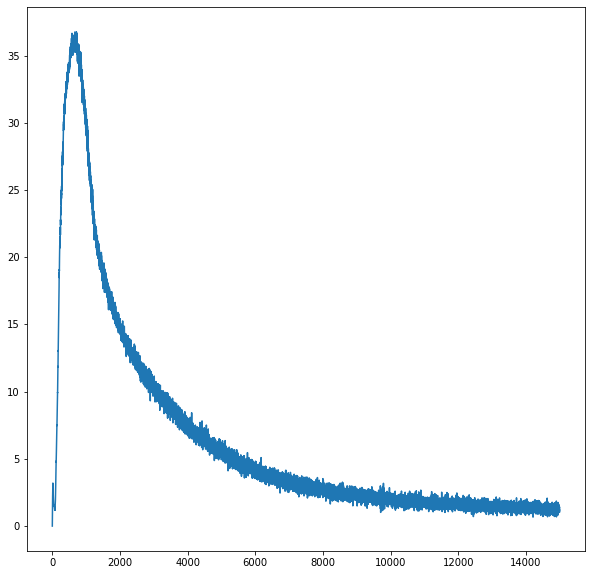

In [86]:
fig = plt.figure(figsize=(10, 10))
plt.plot(losses);

In [87]:
import numpy as np

X = np.linspace(-2, 2, 30)
Y = np.linspace(-2, 2, 30)
grid = np.stack(np.meshgrid(X, Y), axis=-1).reshape(1, -1, 2)
grid_tensor = torch.tensor(grid).float().to(device)
grad_field = score_net(grid_tensor)
grad_field_np = grad_field.detach().cpu().numpy()
grad_field_np = grad_field_np[0]

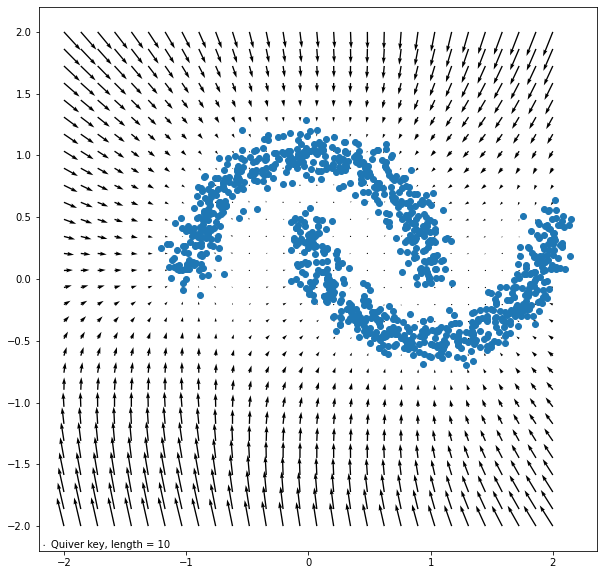

In [90]:
fig, ax = plt.subplots(figsize=(10, 10))
q = ax.quiver(grid[..., 0], grid[..., 1], grad_field_np[..., 0], grad_field_np[..., 1])
ax.quiverkey(q, X=0.01, Y=0.01, U=0.01, label='Quiver key, length = 10', labelpos='E')
sample_data = toy_data.inf_train_gen('moons', n_points=1000)
ax.scatter(sample_data[:, 0], sample_data[:, 1])
plt.show()

<Figure size 720x720 with 0 Axes>

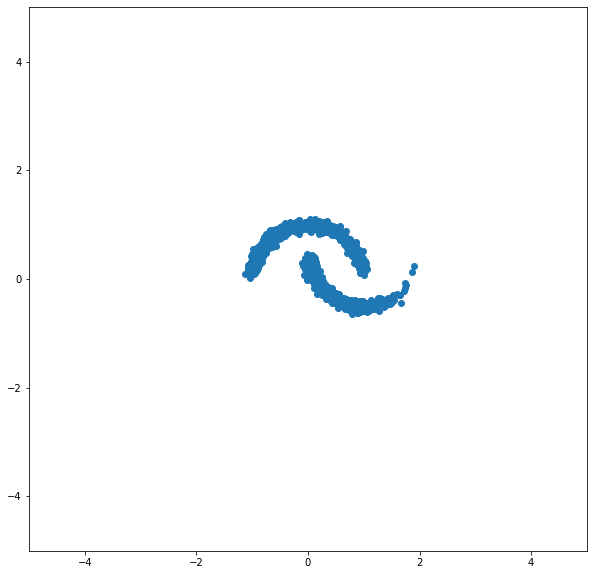

In [94]:
x_final = langevin_dynamics_lsd(score_net, l=0.01, e=.05, num_points=2048)
fig = plt.figure(figsize=(10, 10))
visualize_2d(x_final)